# Reconstrucción del campo de flujo en una cavidad cuadrada
## TP N°3: Influencia de las estrategias de muestreo de puntos de colocación
### Redes Neuronales Informadas por Física - Maestria en Inteligencia Artificial
#### Grupo N°4: Jorge Ceferino Valdez, Fabian Sarmiento y Trinidad Monreal.
---

Buscamos reconstruir el campo de flujo estacionario en una cavidad cuadrada usando una Red Neuronal Informada por Física (PINN). Se trata de resolver las ecuaciones de Navier-Stokes incomprensibles:

$$(\mathbf{u} \cdot \nabla)\mathbf{u} = -\nabla p + \frac{1}{Re} \nabla^2 \mathbf{u} \text{,  en Ω}$$

$$\nabla \cdot \mathbf{u} = 0 \text{,  en Ω}$$

con las siguientes condiciones de borde:

- _No-slip_ en las fronteras laterales e inferior ($\mathbf{u} = (0,0)$)
- Velocidad constante en direccion $+x$ en la frontera superior ($\mathbf{u} = (1,0)$)

y $Ω = [0,1]⊗[0,1]$

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from scipy.io import loadmat
from scipy.interpolate import griddata

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc
from tqdm import trange

np.random.seed(42)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    device_name = "CUDA GPU"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU (MPS)"
else:
    device = torch.device("cpu")
    device_name = "CPU"

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
elif torch.backends.mps.is_available():
    # MPS usa la misma semilla que PyTorch general
    torch.manual_seed(42)

print(f"Usando dispositivo: {device} ({device_name})")

Usando dispositivo: cuda:0 (CUDA GPU)


### Clase PINN Navier-stokes

In [2]:
class PINN_Module(nn.Module):
    """
    Red Neuronal Informada por Física para resolver las ecuaciones de Navier-Stokes
    en una cavidad cuadrada con lid-driven flow
    """
    
    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Re = model_parameters["Re"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        
        # Definir arquitectura de la red
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) 
             for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)
        
        # Inicialización Xavier
        self.init_xavier()

    def forward(self, X):
        """
        Forward pass de la red neuronal
        Input: X tensor de forma (N, 2) con coordenadas (x, y)
        Output: tensor de forma (N, 3) con (u, v, p)
        """
        lb = self.LowerBounds
        ub = self.UpperBounds
        
        # Normalización de entradas a [-1, 1]
        X = 2 * (X - lb) / (ub - lb) - 1
        
        # Forward pass
        output = self.ActivationFunction(self.InputLayer(X))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        
        return output

    def predict(self, X):
        """
        Predicción directa de u, v, p a partir de coordenadas (x, y).
        """
        uvp = self.forward(X)
        u = uvp[:, 0:1]
        v = uvp[:, 1:2]
        p = uvp[:, 2:3]
        return u, v, p

    def init_xavier(self):
        """Inicialización Xavier mejorada de los pesos"""
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                torch.nn.init.xavier_uniform_(m.weight, gain=g)
                # Bias no cero para romper simetría
                torch.nn.init.uniform_(m.bias, -0.1, 0.1)
        
        self.apply(init_weights)

    def navierstokesResidue(self, X, uvp):
        """
        Calcula los residuos de las ecuaciones de Navier-Stokes
        
        Ecuaciones:
        (u·∇)u = -∇p + (1/Re)∇²u  →  u*∂u/∂x + v*∂u/∂y + ∂p/∂x - (1/Re)(∂²u/∂x² + ∂²u/∂y²) = 0
        (u·∇)v = -∇p + (1/Re)∇²v  →  u*∂v/∂x + v*∂v/∂y + ∂p/∂y - (1/Re)(∂²v/∂x² + ∂²v/∂y²) = 0
        ∇·u = ∂u/∂x + ∂v/∂y = 0
        """
        u = uvp[:, 0:1]  # velocidad en x
        v = uvp[:, 1:2]  # velocidad en y
        p = uvp[:, 2:3]  # presión
        
        Re = self.Re
        
        # Derivadas de primer orden usando autodiferenciación
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x = diff_u[:, 0:1]
        u_y = diff_u[:, 1:2]
        
        diff_v = torch.autograd.grad(v, X, create_graph=True, grad_outputs=torch.ones_like(v))[0]
        v_x = diff_v[:, 0:1]
        v_y = diff_v[:, 1:2]
        
        diff_p = torch.autograd.grad(p, X, create_graph=True, grad_outputs=torch.ones_like(p))[0]
        p_x = diff_p[:, 0:1]
        p_y = diff_p[:, 1:2]
        
        # Derivadas de segundo orden
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u_x))[0][:, 0:1]
        u_yy = torch.autograd.grad(u_y, X, create_graph=True, grad_outputs=torch.ones_like(u_y))[0][:, 1:2]
        
        v_xx = torch.autograd.grad(v_x, X, create_graph=True, grad_outputs=torch.ones_like(v_x))[0][:, 0:1]
        v_yy = torch.autograd.grad(v_y, X, create_graph=True, grad_outputs=torch.ones_like(v_y))[0][:, 1:2]
        
        # Residuos de las ecuaciones de momentum
        residue_u = u * u_x + v * u_y + p_x - (1/Re) * (u_xx + u_yy)
        residue_v = u * v_x + v * v_y + p_y - (1/Re) * (v_xx + v_yy)
        
        # Residuo de continuidad
        residue_continuity = u_x + v_y
        
        return residue_u, residue_v, residue_continuity
    
    def compute_residual_norm(self, X):
        uvp = self.forward(X)
        r_u, r_v, _ = self.navierstokesResidue(X, uvp)
        residual_norm = (r_u ** 2 + r_v ** 2).squeeze()
        return residual_norm

#### Configuración del dominio y condiciones de borde

In [3]:
# Parámetros del problema
Re = 100.0  # Número de Reynolds
xi, xf = 0.0, 1.0  # Límites en x
yi, yf = 0.0, 1.0  # Límites en y

# Límites del dominio
lb = torch.tensor([xi, yi], device=device)  # Lower bounds
ub = torch.tensor([xf, yf], device=device)  # Upper bounds

# Condiciones de borde
u_wall = 0.0    # Velocidad en las paredes (no-slip)
v_wall = 0.0    # Velocidad normal en las paredes
u_lid = 1.0     # Velocidad de la tapa superior
v_lid = 0.0     # Velocidad normal en la tapa

print(f"Número de Reynolds: {Re}")
print(f"Dominio: [{xi}, {xf}] x [{yi}, {yf}]")
print(f"Condiciones de borde:")
print(f"  - Paredes laterales e inferior: u=v=0 (no-slip)")
print(f"  - Tapa superior: u={u_lid}, v={v_lid}")

Número de Reynolds: 100.0
Dominio: [0.0, 1.0] x [0.0, 1.0]
Condiciones de borde:
  - Paredes laterales e inferior: u=v=0 (no-slip)
  - Tapa superior: u=1.0, v=0.0


#### Carga de datos de ground-truth

In [4]:
# Cargar datos de los .mat
pressure_mat = loadmat('Re-100/pressure.mat')
velocity_mat = loadmat('Re-100/velocity.mat')

x = pressure_mat['x'].squeeze()
y = pressure_mat['y'].squeeze()
p = pressure_mat['p'].squeeze()
u = velocity_mat['u'].squeeze()
v = velocity_mat['v'].squeeze()

# Reconstruir grilla regular
x_unique = np.linspace(x.min(), x.max(), 201)
y_unique = np.linspace(y.min(), y.max(), 201)
X_grid, Y_grid = np.meshgrid(x_unique, y_unique)

# Interpolar campos sobre la grilla
U_grid = griddata((x, y), u, (X_grid, Y_grid), method='cubic')
V_grid = griddata((x, y), v, (X_grid, Y_grid), method='cubic')
P_grid = griddata((x, y), p, (X_grid, Y_grid), method='cubic')

# Preparar puntos para evaluación del modelo
X_eval = torch.tensor(np.stack([X_grid.flatten(), Y_grid.flatten()], axis=1), dtype=torch.float32, device=device)

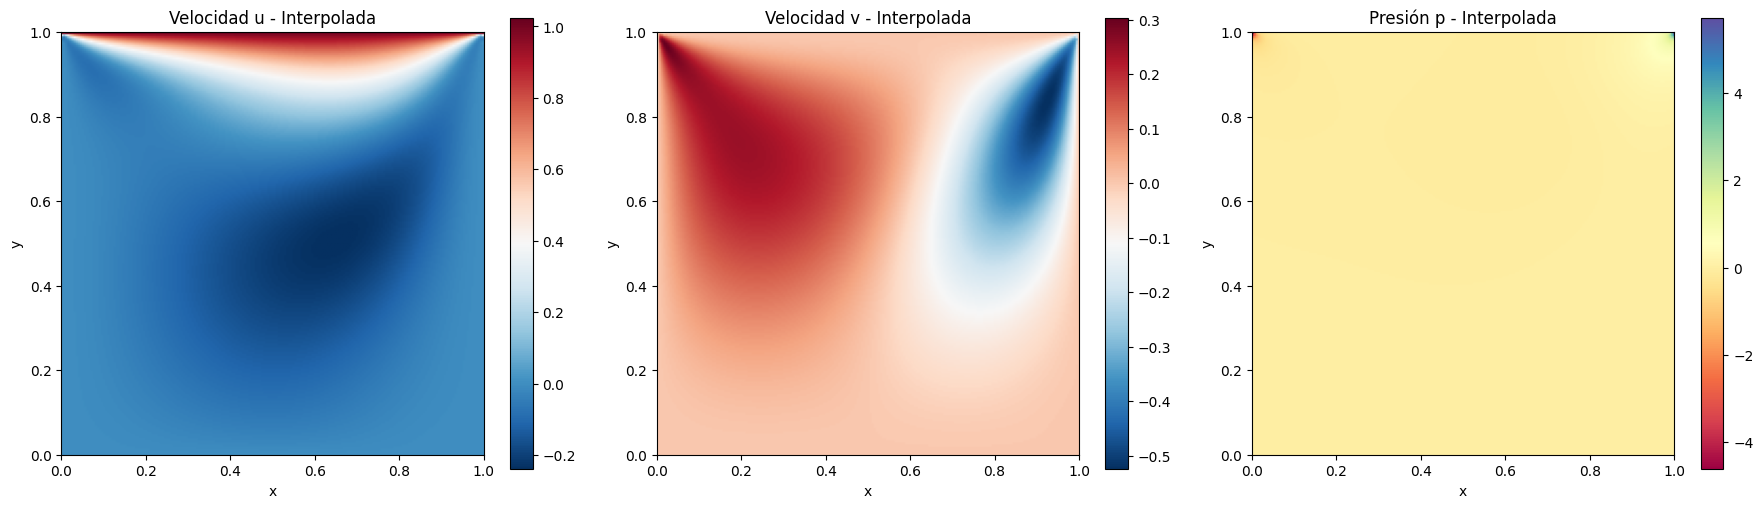

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Campo u
im0 = axs[0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[0].set_title("Velocidad u - Interpolada")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")
plt.colorbar(im0, ax=axs[0])

# Campo v
im1 = axs[1].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='RdBu_r', aspect='equal')
axs[1].set_title("Velocidad v - Interpolada")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")
plt.colorbar(im1, ax=axs[1])

# Campo p
im2 = axs[2].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                    origin='lower', cmap='Spectral', aspect='equal')
axs[2].set_title("Presión p - Interpolada")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.show()

### 1. Estrategias de muestreo de puntos de colocación

*Para el modelo PINN desarrollado en el TP N°2, implementar las siguientes estrategias de muestreo para la construcción de los subconjuntos de puntos de colocación: muestreo aleatorio uniforme, muestreo por el método de hipercubo latino (LHS), y por muestreo adaptativo basado en residuos (estrategia RAD). En este último caso, utilice los residuos de las dos ecuaciones de balance de cantidad de movimiento como métrica para llevar a cabo la estrategia.*

#### (a) Muestreo aleatorio uniforme

In [6]:
def uniform_random_sampling(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs usando muestreo aleatorio uniforme.
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    # PDE points en el dominio [0,1] x [0,1]
    pde_points = torch.rand(N_pde, 2, device=device)

    # Puntos de borde
    N_each = N_bc // 4
    assert N_bc % 4 == 0, "N_bc debe ser divisible por 4 para distribuirlo en las 4 fronteras."
    rand = torch.rand(N_each, device=device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

#### (b) Muestreo por Hipercubo Latino (LHS)

In [7]:
def lhs_1d(N, device):
    """
    Realiza muestreo por hipercubo latino en 1D.
    Divide el intervalo [0,1] en N subintervalos y toma un punto aleatorio en cada uno,
    luego los mezcla aleatoriamente.
    """
    intervals = torch.linspace(0, 1, N + 1, device=device)
    lower_bounds = intervals[:-1]
    upper_bounds = intervals[1:]
    points = lower_bounds + (upper_bounds - lower_bounds) * torch.rand(N, device=device)
    return points[torch.randperm(N)]

def latin_hypercube_sampling(N_pde, N_bc, device):
    """
    Genera puntos de colocación para PINNs usando muestreo por hipercubo latino (LHS).
    - Puntos interiores (PDE)
    - Puntos de borde (BC): bottom, top, left, right
    """
    x_pde = lhs_1d(N_pde, device)
    y_pde = lhs_1d(N_pde, device)
    pde_points = torch.stack([x_pde, y_pde], dim=1)

    N_each = N_bc // 4
    rand = lhs_1d(N_each, device)

    bottom = torch.stack([rand, torch.zeros_like(rand)], dim=1)
    top    = torch.stack([rand, torch.ones_like(rand)], dim=1)
    left   = torch.stack([torch.zeros_like(rand), rand], dim=1)
    right  = torch.stack([torch.ones_like(rand), rand], dim=1)

    bc_points = torch.cat([bottom, top, left, right], dim=0)

    return pde_points, bottom, top, left, right, bc_points

#### (c) Muestreo adaptativo basado en residuos (RAD)

In [8]:
def residual_adaptive_sampling(model, N_pde, device, grid_N=None):
    """
    Genera puntos de colocación para PINNs usando muestreo adaptativo basado en residuos.
    Se asegura que haya suficientes puntos candidatos para seleccionar.
    """
    if grid_N is None:
        grid_N = max(2 * N_pde, 10000)  # mínimo 2*N_pde para garantizar topk

    test_points = torch.rand(grid_N, 2, device=device).requires_grad_(True)
    residual_norm = model.compute_residual_norm(test_points)

    # Asegurar que haya suficientes puntos para seleccionar
    if residual_norm.shape[0] < N_pde:
        raise ValueError(f"Intentando seleccionar {N_pde} puntos pero sólo hay {residual_norm.shape[0]} disponibles.")

    topk = torch.topk(residual_norm, N_pde)
    selected_points = test_points[topk.indices].detach()

    return selected_points

### 2. Para cada estrategia, preparar tres datasets con las siguientes cantidades de puntos.

- *Primer dataset con Npde = 1000 y Nbc = 100.*
- *Segundo dataset con Npde = 10000 y Nbc = 1000.*
- *Tercer dataset con Npde = 100000 y Nbc = 10000.*

Para resolver el punto 2, se implementa una función `generate_collocation_points()` que permite generar datasets de entrenamiento para las tres estrategias de muestreo requeridas: uniforme, hipercubo latino (LHS) y adaptativo por residuos (RAD), variando la cantidad de puntos de colocación según el enunciado. Se generan los datasets en loop dentro del entrenamiento mas adelante.

In [9]:
def generate_collocation_points(strategy, N_pde, N_bc, device, model=None):
    """
    Genera puntos de colocación para entrenamiento PINN según la estrategia indicada.
    
    Parámetros:
    - strategy: "uniform", "lhs" o "rad"
    - N_pde: cantidad de puntos interiores
    - N_bc: cantidad de puntos de borde
    - device: 'cpu' o 'cuda'
    - model: requerido solo si strategy="rad"

    Retorna:
    - pde_points, bottom, top, left, right, bc_points
    """
    if strategy == "uniform":
        return uniform_random_sampling(N_pde, N_bc, device)

    elif strategy == "lhs":
        return latin_hypercube_sampling(N_pde, N_bc, device)

    elif strategy == "rad":
        assert model is not None, "Se requiere un modelo entrenado para RAD."
        pde_points = residual_adaptive_sampling(model, N_pde, device)
        _, bottom, top, left, right, bc_points = uniform_random_sampling(0, N_bc, device)
        return pde_points, bottom, top, left, right, bc_points

    else:
        raise ValueError(f"Estrategia de muestreo desconocida: {strategy}")

In [10]:
strategies = ["uniform", "lhs", "rad"]
point_configs = [
    {"Npde": 1000, "Nbc": 100},
    {"Npde": 10000, "Nbc": 1000},
    {"Npde": 100000, "Nbc": 10000},
]

### 3. Entrenar el modelo PINN para las nueve configuraciones de datasets preparados en el item 2. 

*Con el fin de realizar una comparación “justa”, en todos los casos deberá utilizar la misma configuración de hiperparámetros (tamaño de red, optimizador, cantidad de epochs, etc.), y defina el criterio de selección de dichos valores. Utilice un valor 𝜆bc = 10 para el peso de la componente de la función de pérdida asociada al residuo de las condiciones de borde de velocidad. Calcular en cada caso la norma-2 del error de la misma manera que se realizó en el item 3 del TP N°2*

#### Configuración del modelo

In [11]:
# Parámetros del modelo: mantenemos igual a TP2
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Re": Re,
    "InputDimensions": 2,      # (x, y)
    "OutputDimensions": 3,     # (u, v, p)
    "NumberOfNeurons": 64,    # Era 200 - REDUCIDO por CPU
    "NumberOfHiddenLayers": 5, # Era 12 - REDUCIDO por CPU
    "ActivationFunction": nn.Tanh()
}

In [12]:
# Crear modelo
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)

print("Arquitectura del modelo:")
print(f"  - Entradas: {model_parameters['InputDimensions']} (x, y)")
print(f"  - Salidas: {model_parameters['OutputDimensions']} (u, v, p)")
print(f"  - Capas ocultas: {model_parameters['NumberOfHiddenLayers']}")
print(f"  - Neuronas por capa: {model_parameters['NumberOfNeurons']}")
print(f"  - Función de activación: {model_parameters['ActivationFunction']}")

# Contar parámetros
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  - Total de parámetros entrenables: {total_params}")

Arquitectura del modelo:
  - Entradas: 2 (x, y)
  - Salidas: 3 (u, v, p)
  - Capas ocultas: 5
  - Neuronas por capa: 64
  - Función de activación: Tanh()
  - Total de parámetros entrenables: 17027


### Entrenamiento

In [13]:
def compute_bc_loss(uvp, u_target, v_target, loss_fn):
    loss_u = loss_fn(uvp[:, 0:1], u_target)
    loss_v = loss_fn(uvp[:, 1:2], v_target)
    return loss_u + loss_v

# Función para calcular pérdida de presión de referencia
def compute_pressure_reference_loss(model, loss_fn):
    """
    Calcula la pérdida para forzar que p(0,0) = 0
    Esto elimina la indeterminación de la constante en el campo de presión
    """
    # Punto de referencia (0,0)
    reference_point = torch.tensor([[0.0, 0.0]], device=device, requires_grad=True)
    
    # Evaluar el modelo en el punto de referencia
    uvp_ref = model(reference_point)
    p_ref = uvp_ref[:, 2:3]  # Extraer presión
    
    # La presión en (0,0) debe ser cero
    target_pressure = torch.zeros_like(p_ref)
    
    return loss_fn(p_ref, target_pressure)

# Función de entrenamiento
def train_pinn(model, pde_points, top, bottom, left, right, 
               epochs, optimizer, scheduler,
               weight_pde, lambda_bc, weight_pressure_ref,
               strategy=None, Npde=None, Nbc=None,
               loss_fn=nn.MSELoss()):
    """
    Entrena un modelo PINN para el problema de la cavidad cuadrada.
    Guarda el modelo con nombre basado en la estrategia y el tamaño del dataset.
    """
    # Historial de pérdidas
    loss_train = []
    loss_train_momentum_u = []
    loss_train_momentum_v = []
    loss_train_continuity = []
    loss_train_bc = []
    loss_train_pressure_ref = []

    print("Iniciando entrenamiento ...")
    t0 = datetime.now()

    for epoch in trange(epochs, desc="Entrenando modelo PINN"):
        model.train()
        optimizer.zero_grad()

        # === PDE ===
        pde_points_epoch = pde_points.detach().clone().requires_grad_(True)
        uvp_pde = model(pde_points_epoch)
        res_u, res_v, res_cont = model.navierstokesResidue(pde_points_epoch, uvp_pde)

        # Pérdidas PDE
        loss_u = loss_fn(res_u, torch.zeros_like(res_u))
        loss_v = loss_fn(res_v, torch.zeros_like(res_v))
        loss_cont = loss_fn(res_cont, torch.zeros_like(res_cont))
        loss_pde_total = loss_u + loss_v + loss_cont

        # === BC ===
        uvp_top = model(top)
        uvp_bottom = model(bottom)
        uvp_left = model(left)
        uvp_right = model(right)

        loss_bc_top = compute_bc_loss(uvp_top,
                                      torch.ones_like(uvp_top[:, 0:1]),
                                      torch.zeros_like(uvp_top[:, 1:2]),
                                      loss_fn)
        loss_bc_bottom = compute_bc_loss(uvp_bottom,
                                         torch.zeros_like(uvp_bottom[:, 0:1]),
                                         torch.zeros_like(uvp_bottom[:, 1:2]),
                                         loss_fn)
        loss_bc_left = compute_bc_loss(uvp_left,
                                       torch.zeros_like(uvp_left[:, 0:1]),
                                       torch.zeros_like(uvp_left[:, 1:2]),
                                       loss_fn)
        loss_bc_right = compute_bc_loss(uvp_right,
                                        torch.zeros_like(uvp_right[:, 0:1]),
                                        torch.zeros_like(uvp_right[:, 1:2]),
                                        loss_fn)
        loss_bc_total = loss_bc_top + loss_bc_bottom + loss_bc_left + loss_bc_right

        # === Presión de referencia ===
        loss_pressure_ref = compute_pressure_reference_loss(model, loss_fn)

        # === Pérdida total ===
        loss_total = (weight_pde * loss_pde_total +
                      lambda_bc * loss_bc_total +
                      weight_pressure_ref * loss_pressure_ref)

        loss_total.backward()
        optimizer.step()
        scheduler.step()

        # Guardar pérdidas
        loss_train.append(loss_total.item())
        loss_train_momentum_u.append(loss_u.item())
        loss_train_momentum_v.append(loss_v.item())
        loss_train_continuity.append(loss_cont.item())
        loss_train_bc.append(loss_bc_total.item())
        loss_train_pressure_ref.append(loss_pressure_ref.item())

        # Logs
        if epoch % 500 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                u_top_mean = model(top)[:, 0].mean().item()
                ref_point = torch.tensor([[0.0, 0.0]], device=model.Device)
                p_ref_value = model(ref_point)[0, 2].item()

            print(f"Epoch {epoch:4d} | Total: {loss_total.item():.2e} | PDE: {loss_pde_total.item():.2e} | "
                  f"BC: {loss_bc_total.item():.2e} | P_ref: {loss_pressure_ref.item():.2e} | "
                  f"p(0,0): {p_ref_value:.4f} | u_top: {u_top_mean:.3f}")

    elapsed = datetime.now() - t0
    print(f"\nTiempo total: {elapsed.total_seconds():.1f} segundos")

    # Guardar modelo con nombre descriptivo
    models_dir = "models"
    if not os.path.exists(models_dir):
        os.makedirs(models_dir)

    time_str = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f"pinn_{strategy}_Npde{Npde}_Nbc{Nbc}_{time_str}.pt" if strategy and Npde and Nbc else f"pinn_trained_{time_str}.pt"
    torch.save(model.state_dict(), os.path.join(models_dir, filename))
    print(f"Modelo guardado como: models/{filename}")

    return {
        "total": loss_train,
        "u_momentum": loss_train_momentum_u,
        "v_momentum": loss_train_momentum_v,
        "continuity": loss_train_continuity,
        "bc": loss_train_bc,
        "pressure_ref": loss_train_pressure_ref
    }


#### Gráficos de evolución de pérdidas

In [14]:
# Función para graficar pérdidas con nueva pérdida
def plot_losses(loss_dict):
    loss_list = [
        loss_dict["total"],
        loss_dict["u_momentum"],
        loss_dict["v_momentum"],
        loss_dict["continuity"],
        loss_dict["bc"],
        loss_dict["pressure_ref"]  # NUEVO
    ]
    colors = ['black', 'red', 'green', 'blue', 'magenta', 'orange']  # NUEVO color
    titles = ['Overall Loss', 'Momentum U', 'Momentum V', 'Continuity', 'BC', 'Pressure Ref']  # NUEVO título

    _, ax = plt.subplots(1, len(loss_list), figsize=(25, 4))
    for i, loss in enumerate(loss_list):
        ax[i].loglog(np.arange(len(loss)), loss, color=colors[i])
        ax[i].set_xlabel("Epoch")
        ax[i].set_title(titles[i])
        ax[i].grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_comparacion_uvp(u_pred, v_pred, p_pred, strategy, Npde, Nbc,
                          U_grid, V_grid, P_grid, x, y):
    """
    Plotea comparación de u, v, p entre solución de referencia (MEF) y predicción (PINN),
    incluyendo errores absolutos. 

    Parámetros:
    - u_pred, v_pred, p_pred: resultados del modelo PINN (2D arrays)
    - strategy: nombre de la estrategia ('uniform', 'lhs', 'rad')
    - Npde, Nbc: tamaños del dataset
    - U_grid, V_grid, P_grid: campos de referencia (MEF)
    - x, y: arrays con coordenadas para los ejes
    """
    fig, axs = plt.subplots(3, 3, figsize=(18, 13))

    # --- Velocidad u ---
    im0 = axs[0, 0].imshow(U_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[0, 0].set_title(r"$u_{MEF}$")
    axs[0, 0].set_ylabel("y")
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(u_pred, extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[0, 1].set_title(r"$u_{PINN}$")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[0, 2].imshow(np.abs(u_pred - U_grid), extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='Reds', aspect='equal')
    axs[0, 2].set_title(r"$|u_{PINN} - u_{MEF}|$")
    plt.colorbar(im2, ax=axs[0, 2])

    # --- Velocidad v ---
    im3 = axs[1, 0].imshow(V_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[1, 0].set_title(r"$v_{MEF}$")
    axs[1, 0].set_ylabel("y")
    plt.colorbar(im3, ax=axs[1, 0])

    im4 = axs[1, 1].imshow(v_pred, extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='RdBu_r', aspect='equal')
    axs[1, 1].set_title(r"$v_{PINN}$")
    plt.colorbar(im4, ax=axs[1, 1])

    im5 = axs[1, 2].imshow(np.abs(v_pred - V_grid), extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='Reds', aspect='equal')
    axs[1, 2].set_title(r"$|v_{PINN} - v_{MEF}|$")
    plt.colorbar(im5, ax=axs[1, 2])

    # --- Presión p ---
    im6 = axs[2, 0].imshow(P_grid, extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='Spectral', aspect='equal')
    axs[2, 0].set_title(r"$p_{MEF}$")
    axs[2, 0].set_ylabel("y")
    axs[2, 0].set_xlabel("x")
    plt.colorbar(im6, ax=axs[2, 0])

    im7 = axs[2, 1].imshow(p_pred, extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='Spectral', aspect='equal')
    axs[2, 1].set_title(r"$p_{PINN}$")
    axs[2, 1].set_xlabel("x")
    plt.colorbar(im7, ax=axs[2, 1])

    im8 = axs[2, 2].imshow(np.abs(p_pred - P_grid), extent=[x.min(), x.max(), y.min(), y.max()],
                           origin='lower', cmap='Reds', aspect='equal')
    axs[2, 2].set_title(r"$|p_{PINN} - p_{MEF}|$")
    axs[2, 2].set_xlabel("x")
    plt.colorbar(im8, ax=axs[2, 2])

    plt.suptitle(f"Comparación de campos: {strategy.upper()} - Npde={Npde}, Nbc={Nbc}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # espacio para el título
    plt.show()



=== Entrenando modelo: uniform_Npde1000_Nbc100 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 1/10000 [00:00<19:56,  8.36it/s]

Epoch    0 | Total: 8.14e+03 | PDE: 4.83e+01 | BC: 5.02e+00 | P_ref: 3.26e-01 | p(0,0): 0.8894 | u_top: 0.832


Entrenando modelo PINN:   5%|▌         | 508/10000 [00:07<02:13, 71.18it/s]

Epoch  500 | Total: 5.03e+00 | PDE: 1.85e-02 | BC: 3.18e-01 | P_ref: 3.00e-09 | p(0,0): -0.0001 | u_top: 0.592


Entrenando modelo PINN:  10%|█         | 1012/10000 [00:14<02:04, 72.02it/s]

Epoch 1000 | Total: 3.49e+00 | PDE: 8.37e-03 | BC: 2.65e-01 | P_ref: 4.00e-10 | p(0,0): -0.0000 | u_top: 0.669


Entrenando modelo PINN:  15%|█▌        | 1508/10000 [00:21<01:58, 71.78it/s]

Epoch 1500 | Total: 2.96e+00 | PDE: 5.42e-03 | BC: 2.41e-01 | P_ref: 6.34e-11 | p(0,0): -0.0000 | u_top: 0.698


Entrenando modelo PINN:  20%|██        | 2011/10000 [00:28<01:55, 69.01it/s]

Epoch 2000 | Total: 2.68e+00 | PDE: 4.08e-03 | BC: 2.27e-01 | P_ref: 8.49e-12 | p(0,0): -0.0000 | u_top: 0.717


Entrenando modelo PINN:  25%|██▌       | 2512/10000 [00:35<01:52, 66.65it/s]

Epoch 2500 | Total: 2.51e+00 | PDE: 3.38e-03 | BC: 2.18e-01 | P_ref: 1.33e-13 | p(0,0): -0.0000 | u_top: 0.730


Entrenando modelo PINN:  30%|███       | 3013/10000 [00:42<01:35, 73.44it/s]

Epoch 3000 | Total: 2.40e+00 | PDE: 2.95e-03 | BC: 2.11e-01 | P_ref: 3.90e-12 | p(0,0): 0.0000 | u_top: 0.739


Entrenando modelo PINN:  35%|███▌      | 3508/10000 [00:49<01:37, 66.44it/s]

Epoch 3500 | Total: 2.32e+00 | PDE: 2.67e-03 | BC: 2.05e-01 | P_ref: 7.52e-12 | p(0,0): 0.0000 | u_top: 0.747


Entrenando modelo PINN:  40%|████      | 4012/10000 [00:56<01:29, 66.81it/s]

Epoch 4000 | Total: 2.25e+00 | PDE: 2.46e-03 | BC: 2.01e-01 | P_ref: 1.58e-11 | p(0,0): 0.0000 | u_top: 0.754


Entrenando modelo PINN:  45%|████▌     | 4513/10000 [01:03<01:13, 74.27it/s]

Epoch 4500 | Total: 2.20e+00 | PDE: 2.30e-03 | BC: 1.97e-01 | P_ref: 1.12e-11 | p(0,0): 0.0000 | u_top: 0.759


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:10<01:07, 74.12it/s]

Epoch 5000 | Total: 2.15e+00 | PDE: 2.18e-03 | BC: 1.93e-01 | P_ref: 8.88e-12 | p(0,0): 0.0000 | u_top: 0.764


Entrenando modelo PINN:  55%|█████▌    | 5508/10000 [01:17<01:06, 67.21it/s]

Epoch 5500 | Total: 2.11e+00 | PDE: 2.08e-03 | BC: 1.90e-01 | P_ref: 1.10e-11 | p(0,0): 0.0000 | u_top: 0.768


Entrenando modelo PINN:  60%|██████    | 6012/10000 [01:24<00:58, 67.72it/s]

Epoch 6000 | Total: 2.08e+00 | PDE: 1.99e-03 | BC: 1.88e-01 | P_ref: 4.77e-12 | p(0,0): 0.0000 | u_top: 0.772


Entrenando modelo PINN:  65%|██████▌   | 6511/10000 [01:32<00:48, 72.18it/s]

Epoch 6500 | Total: 2.04e+00 | PDE: 1.92e-03 | BC: 1.85e-01 | P_ref: 1.03e-11 | p(0,0): 0.0000 | u_top: 0.776


Entrenando modelo PINN:  70%|███████   | 7015/10000 [01:39<00:40, 73.48it/s]

Epoch 7000 | Total: 2.02e+00 | PDE: 1.85e-03 | BC: 1.83e-01 | P_ref: 9.29e-12 | p(0,0): 0.0000 | u_top: 0.779


Entrenando modelo PINN:  75%|███████▌  | 7511/10000 [01:45<00:33, 73.56it/s]

Epoch 7500 | Total: 1.99e+00 | PDE: 1.80e-03 | BC: 1.81e-01 | P_ref: 7.04e-12 | p(0,0): 0.0000 | u_top: 0.782


Entrenando modelo PINN:  80%|████████  | 8015/10000 [01:52<00:27, 71.22it/s]

Epoch 8000 | Total: 1.96e+00 | PDE: 1.74e-03 | BC: 1.79e-01 | P_ref: 4.02e-12 | p(0,0): 0.0000 | u_top: 0.785


Entrenando modelo PINN:  85%|████████▌ | 8510/10000 [01:59<00:21, 70.03it/s]

Epoch 8500 | Total: 1.94e+00 | PDE: 1.70e-03 | BC: 1.77e-01 | P_ref: 9.09e-13 | p(0,0): 0.0000 | u_top: 0.787


Entrenando modelo PINN:  90%|█████████ | 9010/10000 [02:06<00:13, 72.02it/s]

Epoch 9000 | Total: 1.92e+00 | PDE: 1.65e-03 | BC: 1.76e-01 | P_ref: 6.01e-12 | p(0,0): 0.0000 | u_top: 0.790


Entrenando modelo PINN:  95%|█████████▌| 9511/10000 [02:13<00:07, 69.43it/s]

Epoch 9500 | Total: 1.90e+00 | PDE: 1.61e-03 | BC: 1.74e-01 | P_ref: 8.26e-13 | p(0,0): 0.0000 | u_top: 0.792


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:20<00:00, 71.13it/s]


Epoch 9999 | Total: 1.88e+00 | PDE: 1.57e-03 | BC: 1.73e-01 | P_ref: 1.37e-12 | p(0,0): 0.0000 | u_top: 0.794

Tiempo total: 140.6 segundos
Modelo guardado como: models/pinn_uniform_Npde1000_Nbc100_20250727_180305.pt
Plotting training losses for uniform_Npde1000_Nbc100


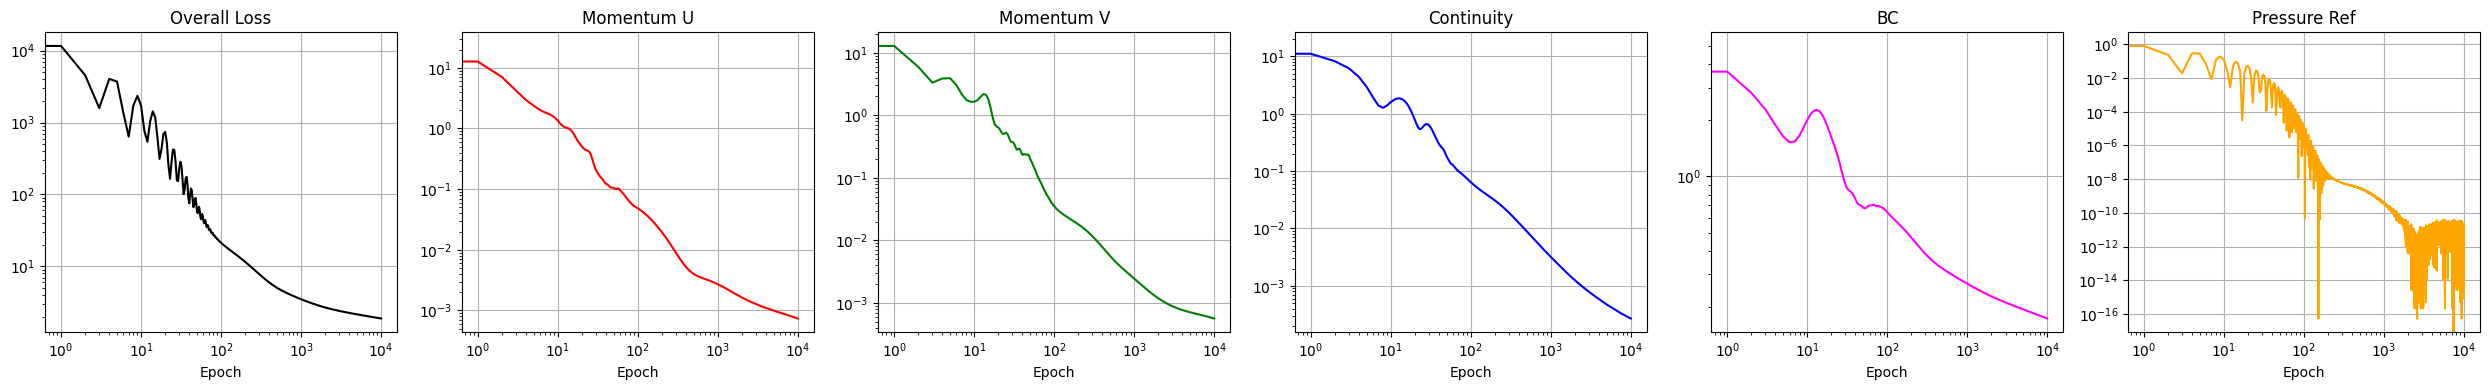

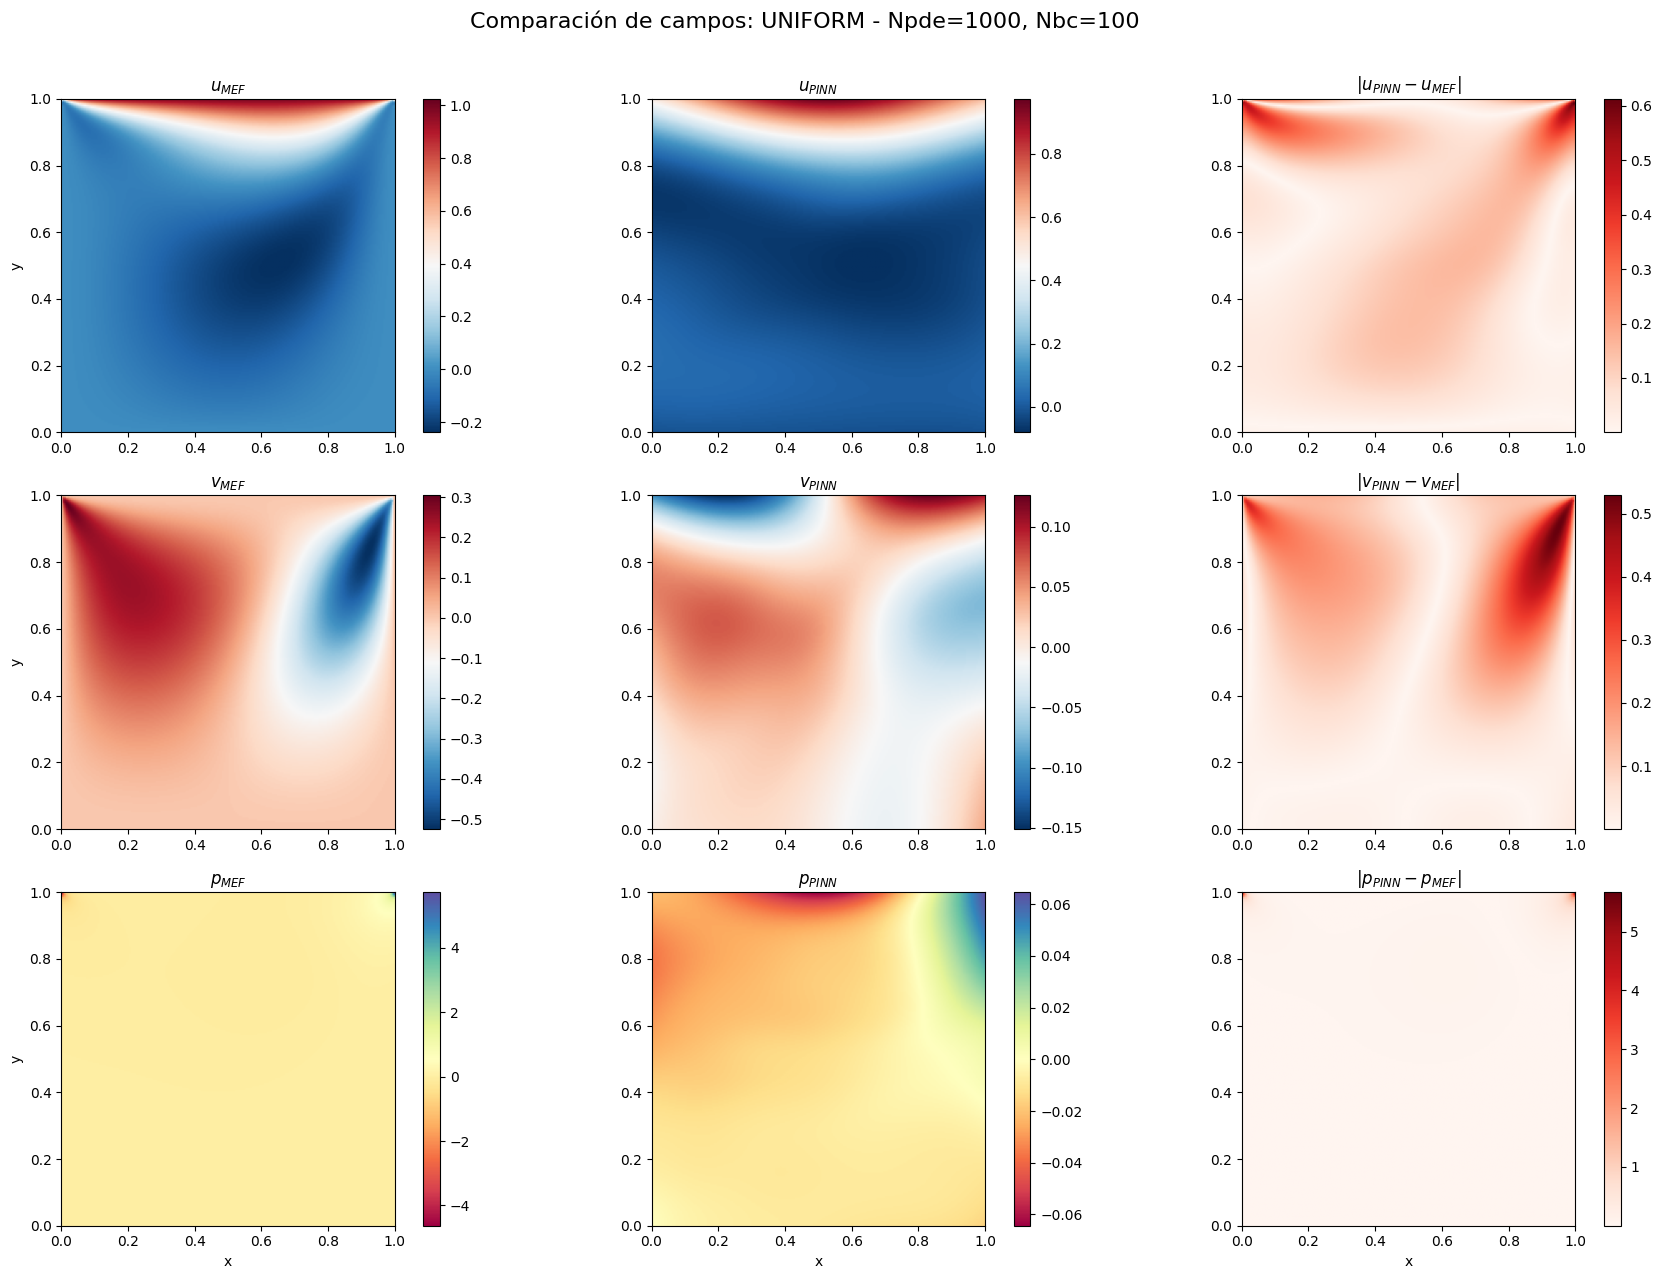


=== Entrenando modelo: uniform_Npde10000_Nbc1000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 6/10000 [00:00<02:54, 57.41it/s]

Epoch    0 | Total: 8.36e+03 | PDE: 5.05e+01 | BC: 5.70e+00 | P_ref: 3.26e-01 | p(0,0): 0.8830 | u_top: 0.819


Entrenando modelo PINN:   5%|▌         | 509/10000 [00:07<02:13, 71.28it/s]

Epoch  500 | Total: 4.15e+00 | PDE: 1.84e-02 | BC: 2.31e-01 | P_ref: 3.38e-09 | p(0,0): -0.0001 | u_top: 0.668


Entrenando modelo PINN:  10%|█         | 1008/10000 [00:14<02:11, 68.39it/s]

Epoch 1000 | Total: 2.56e+00 | PDE: 8.39e-03 | BC: 1.72e-01 | P_ref: 6.52e-10 | p(0,0): -0.0000 | u_top: 0.764


Entrenando modelo PINN:  15%|█▌        | 1509/10000 [00:21<01:59, 71.11it/s]

Epoch 1500 | Total: 2.03e+00 | PDE: 5.34e-03 | BC: 1.49e-01 | P_ref: 1.22e-10 | p(0,0): -0.0000 | u_top: 0.796


Entrenando modelo PINN:  20%|██        | 2012/10000 [00:28<01:59, 67.05it/s]

Epoch 2000 | Total: 1.76e+00 | PDE: 3.92e-03 | BC: 1.37e-01 | P_ref: 4.51e-11 | p(0,0): -0.0000 | u_top: 0.814


Entrenando modelo PINN:  25%|██▌       | 2511/10000 [00:36<01:48, 68.87it/s]

Epoch 2500 | Total: 1.61e+00 | PDE: 3.15e-03 | BC: 1.29e-01 | P_ref: 2.11e-12 | p(0,0): -0.0000 | u_top: 0.827


Entrenando modelo PINN:  30%|███       | 3010/10000 [00:43<01:37, 71.60it/s]

Epoch 3000 | Total: 1.51e+00 | PDE: 2.67e-03 | BC: 1.24e-01 | P_ref: 1.39e-15 | p(0,0): 0.0000 | u_top: 0.836


Entrenando modelo PINN:  35%|███▌      | 3508/10000 [00:50<01:29, 72.23it/s]

Epoch 3500 | Total: 1.43e+00 | PDE: 2.34e-03 | BC: 1.20e-01 | P_ref: 2.24e-12 | p(0,0): -0.0000 | u_top: 0.843


Entrenando modelo PINN:  40%|████      | 4008/10000 [00:57<01:22, 72.55it/s]

Epoch 4000 | Total: 1.37e+00 | PDE: 2.11e-03 | BC: 1.16e-01 | P_ref: 1.53e-12 | p(0,0): -0.0000 | u_top: 0.849


Entrenando modelo PINN:  45%|████▌     | 4512/10000 [01:04<01:16, 71.29it/s]

Epoch 4500 | Total: 1.33e+00 | PDE: 1.93e-03 | BC: 1.13e-01 | P_ref: 1.11e-11 | p(0,0): 0.0000 | u_top: 0.853


Entrenando modelo PINN:  50%|█████     | 5012/10000 [01:11<01:09, 72.03it/s]

Epoch 5000 | Total: 1.29e+00 | PDE: 1.78e-03 | BC: 1.11e-01 | P_ref: 6.12e-12 | p(0,0): 0.0000 | u_top: 0.857


Entrenando modelo PINN:  55%|█████▌    | 5514/10000 [01:18<00:59, 74.89it/s]

Epoch 5500 | Total: 1.25e+00 | PDE: 1.67e-03 | BC: 1.09e-01 | P_ref: 1.14e-11 | p(0,0): 0.0000 | u_top: 0.861


Entrenando modelo PINN:  60%|██████    | 6010/10000 [01:25<00:55, 72.49it/s]

Epoch 6000 | Total: 1.23e+00 | PDE: 1.57e-03 | BC: 1.07e-01 | P_ref: 1.98e-12 | p(0,0): 0.0000 | u_top: 0.864


Entrenando modelo PINN:  65%|██████▌   | 6509/10000 [01:32<00:52, 66.42it/s]

Epoch 6500 | Total: 1.20e+00 | PDE: 1.49e-03 | BC: 1.05e-01 | P_ref: 7.44e-12 | p(0,0): -0.0000 | u_top: 0.867


Entrenando modelo PINN:  70%|███████   | 7013/10000 [01:40<00:41, 72.62it/s]

Epoch 7000 | Total: 1.18e+00 | PDE: 1.42e-03 | BC: 1.03e-01 | P_ref: 3.17e-12 | p(0,0): 0.0000 | u_top: 0.869


Entrenando modelo PINN:  75%|███████▌  | 7510/10000 [01:47<00:36, 68.09it/s]

Epoch 7500 | Total: 1.16e+00 | PDE: 1.36e-03 | BC: 1.02e-01 | P_ref: 3.20e-12 | p(0,0): 0.0000 | u_top: 0.871


Entrenando modelo PINN:  80%|████████  | 8012/10000 [01:54<00:27, 71.42it/s]

Epoch 8000 | Total: 1.14e+00 | PDE: 1.31e-03 | BC: 1.01e-01 | P_ref: 8.02e-12 | p(0,0): 0.0000 | u_top: 0.874


Entrenando modelo PINN:  85%|████████▌ | 8511/10000 [02:01<00:20, 71.82it/s]

Epoch 8500 | Total: 1.12e+00 | PDE: 1.26e-03 | BC: 9.94e-02 | P_ref: 7.97e-12 | p(0,0): 0.0000 | u_top: 0.875


Entrenando modelo PINN:  90%|█████████ | 9009/10000 [02:08<00:13, 72.48it/s]

Epoch 9000 | Total: 1.10e+00 | PDE: 1.22e-03 | BC: 9.83e-02 | P_ref: 1.52e-11 | p(0,0): 0.0000 | u_top: 0.877


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [02:15<00:06, 72.35it/s]

Epoch 9500 | Total: 1.09e+00 | PDE: 1.18e-03 | BC: 9.72e-02 | P_ref: 8.40e-12 | p(0,0): 0.0000 | u_top: 0.879


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:22<00:00, 70.13it/s]


Epoch 9999 | Total: 1.08e+00 | PDE: 1.15e-03 | BC: 9.62e-02 | P_ref: 1.93e-13 | p(0,0): 0.0000 | u_top: 0.880

Tiempo total: 142.6 segundos
Modelo guardado como: models/pinn_uniform_Npde10000_Nbc1000_20250727_180531.pt
Plotting training losses for uniform_Npde10000_Nbc1000


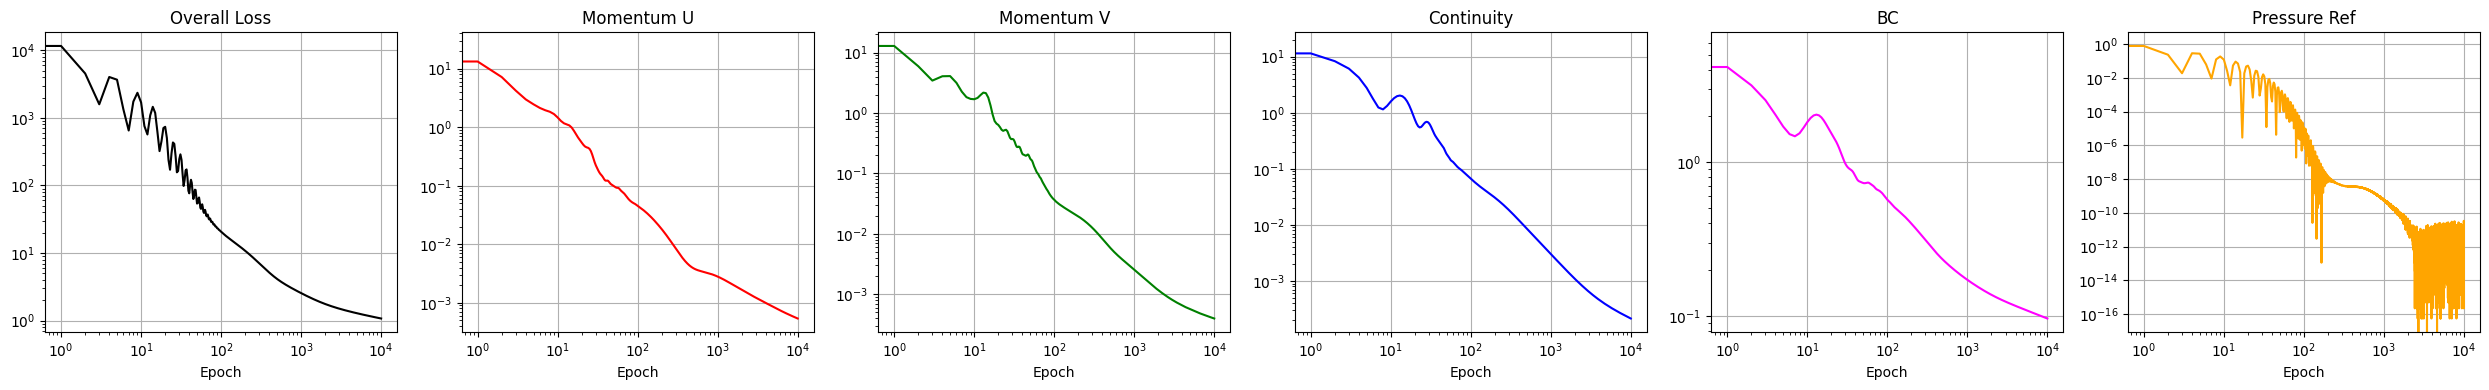

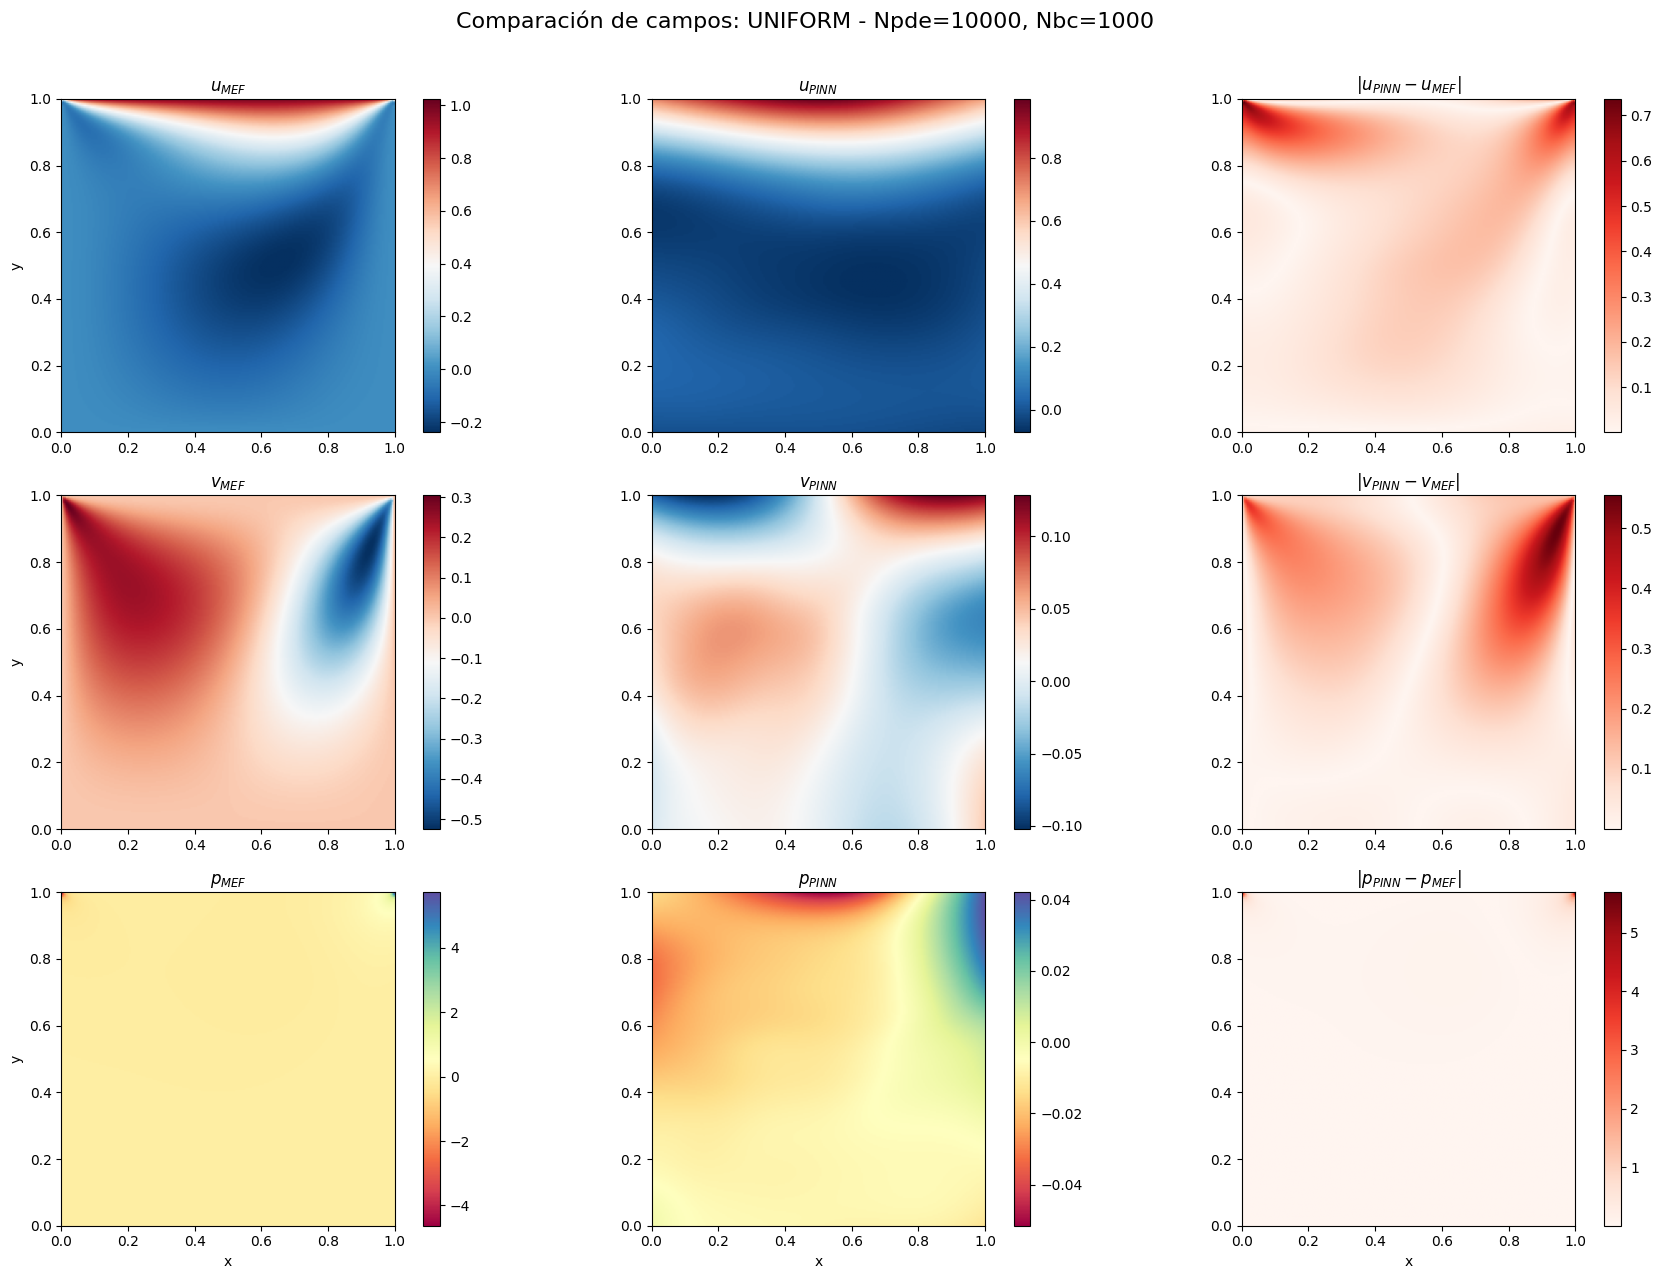


=== Entrenando modelo: uniform_Npde100000_Nbc10000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 2/10000 [00:00<14:22, 11.60it/s]

Epoch    0 | Total: 8.25e+03 | PDE: 4.94e+01 | BC: 5.67e+00 | P_ref: 3.26e-01 | p(0,0): 0.8881 | u_top: 0.818


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:40<13:06, 12.07it/s]

Epoch  500 | Total: 4.21e+00 | PDE: 1.82e-02 | BC: 2.38e-01 | P_ref: 3.09e-09 | p(0,0): -0.0001 | u_top: 0.661


Entrenando modelo PINN:  10%|█         | 1002/10000 [01:21<12:22, 12.13it/s]

Epoch 1000 | Total: 2.59e+00 | PDE: 8.37e-03 | BC: 1.76e-01 | P_ref: 5.65e-10 | p(0,0): -0.0000 | u_top: 0.757


Entrenando modelo PINN:  15%|█▌        | 1502/10000 [02:01<11:22, 12.45it/s]

Epoch 1500 | Total: 2.05e+00 | PDE: 5.33e-03 | BC: 1.52e-01 | P_ref: 8.76e-11 | p(0,0): -0.0000 | u_top: 0.790


Entrenando modelo PINN:  20%|██        | 2002/10000 [02:41<10:47, 12.36it/s]

Epoch 2000 | Total: 1.78e+00 | PDE: 3.93e-03 | BC: 1.38e-01 | P_ref: 9.56e-12 | p(0,0): -0.0000 | u_top: 0.810


Entrenando modelo PINN:  25%|██▌       | 2502/10000 [03:21<09:53, 12.64it/s]

Epoch 2500 | Total: 1.62e+00 | PDE: 3.17e-03 | BC: 1.30e-01 | P_ref: 3.72e-12 | p(0,0): 0.0000 | u_top: 0.823


Entrenando modelo PINN:  30%|███       | 3002/10000 [04:00<09:15, 12.59it/s]

Epoch 3000 | Total: 1.51e+00 | PDE: 2.71e-03 | BC: 1.24e-01 | P_ref: 1.17e-12 | p(0,0): 0.0000 | u_top: 0.833


Entrenando modelo PINN:  35%|███▌      | 3502/10000 [04:40<08:43, 12.40it/s]

Epoch 3500 | Total: 1.43e+00 | PDE: 2.40e-03 | BC: 1.19e-01 | P_ref: 6.96e-13 | p(0,0): 0.0000 | u_top: 0.841


Entrenando modelo PINN:  40%|████      | 4002/10000 [05:20<07:56, 12.59it/s]

Epoch 4000 | Total: 1.37e+00 | PDE: 2.17e-03 | BC: 1.15e-01 | P_ref: 5.37e-12 | p(0,0): 0.0000 | u_top: 0.847


Entrenando modelo PINN:  45%|████▌     | 4502/10000 [06:00<07:12, 12.71it/s]

Epoch 4500 | Total: 1.32e+00 | PDE: 1.99e-03 | BC: 1.12e-01 | P_ref: 1.32e-11 | p(0,0): 0.0000 | u_top: 0.852


Entrenando modelo PINN:  50%|█████     | 5002/10000 [06:40<06:54, 12.05it/s]

Epoch 5000 | Total: 1.28e+00 | PDE: 1.85e-03 | BC: 1.09e-01 | P_ref: 1.20e-11 | p(0,0): 0.0000 | u_top: 0.857


Entrenando modelo PINN:  55%|█████▌    | 5502/10000 [07:20<06:02, 12.39it/s]

Epoch 5500 | Total: 1.24e+00 | PDE: 1.74e-03 | BC: 1.07e-01 | P_ref: 5.37e-12 | p(0,0): 0.0000 | u_top: 0.860


Entrenando modelo PINN:  60%|██████    | 6002/10000 [08:00<05:18, 12.55it/s]

Epoch 6000 | Total: 1.21e+00 | PDE: 1.64e-03 | BC: 1.04e-01 | P_ref: 1.47e-12 | p(0,0): 0.0000 | u_top: 0.864


Entrenando modelo PINN:  65%|██████▌   | 6502/10000 [08:40<04:40, 12.49it/s]

Epoch 6500 | Total: 1.18e+00 | PDE: 1.56e-03 | BC: 1.02e-01 | P_ref: 9.61e-12 | p(0,0): 0.0000 | u_top: 0.867


Entrenando modelo PINN:  70%|███████   | 7002/10000 [09:19<03:56, 12.69it/s]

Epoch 7000 | Total: 1.16e+00 | PDE: 1.49e-03 | BC: 1.01e-01 | P_ref: 1.01e-11 | p(0,0): 0.0000 | u_top: 0.870


Entrenando modelo PINN:  75%|███████▌  | 7502/10000 [10:00<03:18, 12.60it/s]

Epoch 7500 | Total: 1.13e+00 | PDE: 1.43e-03 | BC: 9.89e-02 | P_ref: 1.05e-11 | p(0,0): 0.0000 | u_top: 0.872


Entrenando modelo PINN:  80%|████████  | 8002/10000 [10:40<02:40, 12.43it/s]

Epoch 8000 | Total: 1.11e+00 | PDE: 1.38e-03 | BC: 9.73e-02 | P_ref: 1.73e-11 | p(0,0): 0.0000 | u_top: 0.875


Entrenando modelo PINN:  85%|████████▌ | 8502/10000 [11:20<01:59, 12.56it/s]

Epoch 8500 | Total: 1.09e+00 | PDE: 1.33e-03 | BC: 9.59e-02 | P_ref: 2.86e-12 | p(0,0): 0.0000 | u_top: 0.877


Entrenando modelo PINN:  90%|█████████ | 9002/10000 [12:00<01:19, 12.55it/s]

Epoch 9000 | Total: 1.07e+00 | PDE: 1.29e-03 | BC: 9.45e-02 | P_ref: 6.72e-12 | p(0,0): 0.0000 | u_top: 0.879


Entrenando modelo PINN:  95%|█████████▌| 9502/10000 [12:41<00:40, 12.19it/s]

Epoch 9500 | Total: 1.06e+00 | PDE: 1.25e-03 | BC: 9.33e-02 | P_ref: 1.39e-15 | p(0,0): 0.0000 | u_top: 0.881


Entrenando modelo PINN: 100%|██████████| 10000/10000 [13:22<00:00, 12.47it/s]


Epoch 9999 | Total: 1.04e+00 | PDE: 1.21e-03 | BC: 9.21e-02 | P_ref: 1.66e-12 | p(0,0): 0.0000 | u_top: 0.883

Tiempo total: 802.1 segundos
Modelo guardado como: models/pinn_uniform_Npde100000_Nbc10000_20250727_181855.pt
Plotting training losses for uniform_Npde100000_Nbc10000


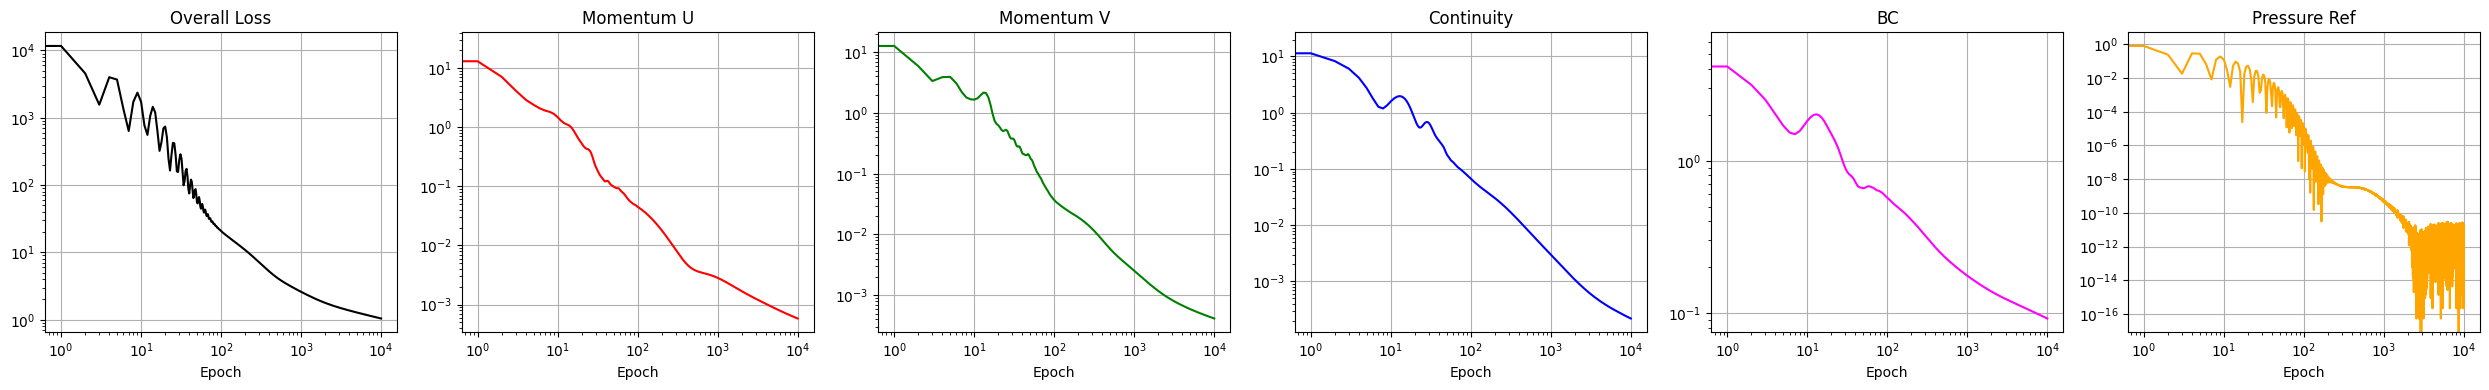

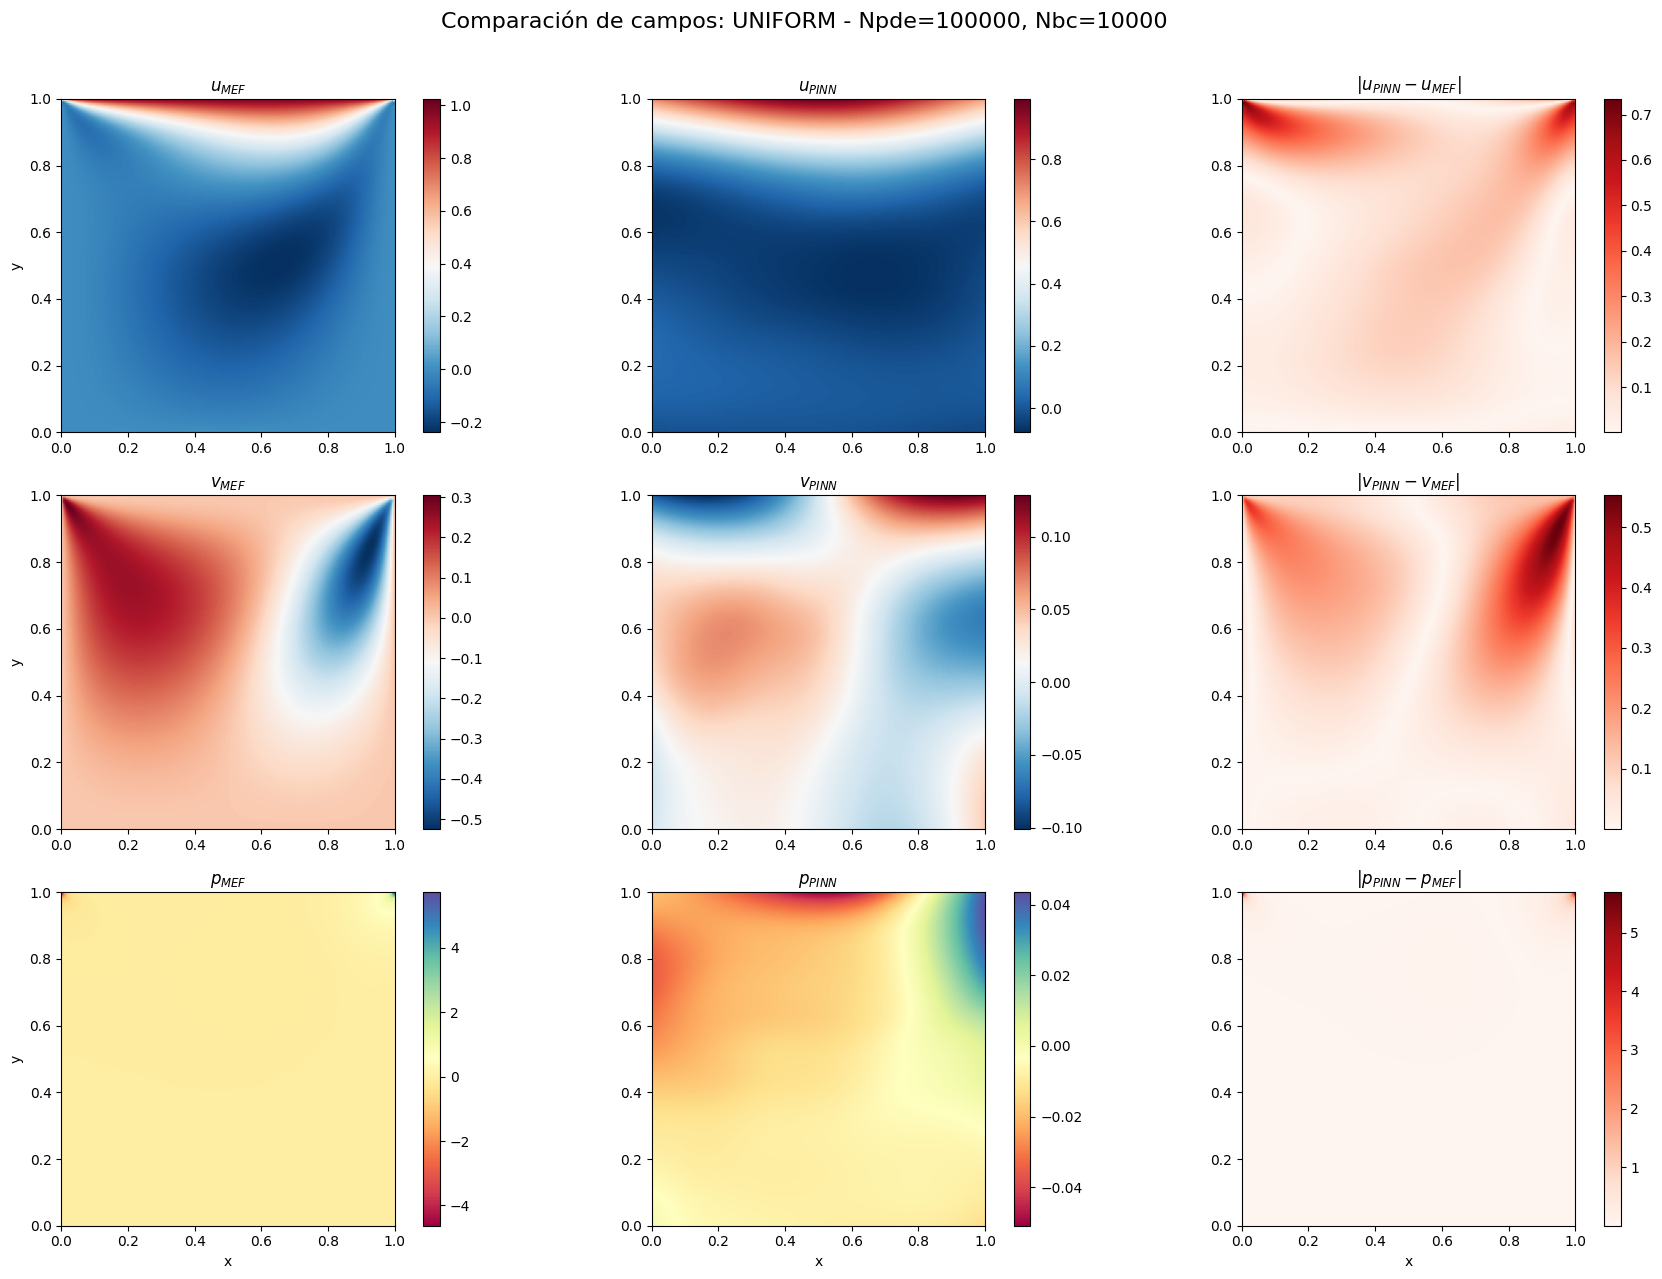


=== Entrenando modelo: lhs_Npde1000_Nbc100 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 7/10000 [00:00<02:24, 69.32it/s]

Epoch    0 | Total: 8.24e+03 | PDE: 4.93e+01 | BC: 5.58e+00 | P_ref: 3.26e-01 | p(0,0): 0.8863 | u_top: 0.823


Entrenando modelo PINN:   5%|▌         | 514/10000 [00:07<02:11, 71.90it/s]

Epoch  500 | Total: 4.26e+00 | PDE: 1.78e-02 | BC: 2.48e-01 | P_ref: 1.53e-09 | p(0,0): -0.0000 | u_top: 0.648


Entrenando modelo PINN:  10%|█         | 1014/10000 [00:14<02:09, 69.64it/s]

Epoch 1000 | Total: 2.62e+00 | PDE: 8.15e-03 | BC: 1.80e-01 | P_ref: 3.64e-10 | p(0,0): -0.0000 | u_top: 0.751


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:21<01:55, 73.31it/s]

Epoch 1500 | Total: 2.10e+00 | PDE: 5.36e-03 | BC: 1.57e-01 | P_ref: 6.68e-11 | p(0,0): -0.0000 | u_top: 0.786


Entrenando modelo PINN:  20%|██        | 2011/10000 [00:28<02:02, 65.14it/s]

Epoch 2000 | Total: 1.84e+00 | PDE: 3.99e-03 | BC: 1.44e-01 | P_ref: 7.60e-12 | p(0,0): -0.0000 | u_top: 0.806


Entrenando modelo PINN:  25%|██▌       | 2508/10000 [00:36<01:52, 66.81it/s]

Epoch 2500 | Total: 1.68e+00 | PDE: 3.21e-03 | BC: 1.36e-01 | P_ref: 5.83e-12 | p(0,0): -0.0000 | u_top: 0.818


Entrenando modelo PINN:  30%|███       | 3014/10000 [00:43<01:36, 72.48it/s]

Epoch 3000 | Total: 1.58e+00 | PDE: 2.74e-03 | BC: 1.30e-01 | P_ref: 4.01e-13 | p(0,0): 0.0000 | u_top: 0.828


Entrenando modelo PINN:  35%|███▌      | 3512/10000 [00:50<01:34, 68.45it/s]

Epoch 3500 | Total: 1.50e+00 | PDE: 2.42e-03 | BC: 1.26e-01 | P_ref: 5.94e-12 | p(0,0): -0.0000 | u_top: 0.835


Entrenando modelo PINN:  40%|████      | 4014/10000 [00:57<01:26, 69.38it/s]

Epoch 4000 | Total: 1.44e+00 | PDE: 2.18e-03 | BC: 1.22e-01 | P_ref: 5.23e-12 | p(0,0): 0.0000 | u_top: 0.841


Entrenando modelo PINN:  45%|████▌     | 4514/10000 [01:04<01:17, 71.18it/s]

Epoch 4500 | Total: 1.39e+00 | PDE: 2.00e-03 | BC: 1.19e-01 | P_ref: 8.06e-12 | p(0,0): 0.0000 | u_top: 0.845


Entrenando modelo PINN:  50%|█████     | 5009/10000 [01:11<01:08, 73.29it/s]

Epoch 5000 | Total: 1.35e+00 | PDE: 1.86e-03 | BC: 1.17e-01 | P_ref: 6.30e-12 | p(0,0): 0.0000 | u_top: 0.849


Entrenando modelo PINN:  55%|█████▌    | 5513/10000 [01:18<01:03, 71.06it/s]

Epoch 5500 | Total: 1.32e+00 | PDE: 1.75e-03 | BC: 1.14e-01 | P_ref: 1.04e-11 | p(0,0): 0.0000 | u_top: 0.853


Entrenando modelo PINN:  60%|██████    | 6009/10000 [01:25<00:56, 71.26it/s]

Epoch 6000 | Total: 1.29e+00 | PDE: 1.65e-03 | BC: 1.12e-01 | P_ref: 4.02e-12 | p(0,0): 0.0000 | u_top: 0.856


Entrenando modelo PINN:  65%|██████▌   | 6508/10000 [01:32<00:53, 65.43it/s]

Epoch 6500 | Total: 1.26e+00 | PDE: 1.57e-03 | BC: 1.10e-01 | P_ref: 1.01e-12 | p(0,0): 0.0000 | u_top: 0.859


Entrenando modelo PINN:  70%|███████   | 7012/10000 [01:40<00:49, 60.20it/s]

Epoch 7000 | Total: 1.24e+00 | PDE: 1.50e-03 | BC: 1.09e-01 | P_ref: 1.96e-11 | p(0,0): 0.0000 | u_top: 0.862


Entrenando modelo PINN:  75%|███████▌  | 7513/10000 [01:48<00:33, 73.93it/s]

Epoch 7500 | Total: 1.22e+00 | PDE: 1.44e-03 | BC: 1.07e-01 | P_ref: 3.84e-12 | p(0,0): 0.0000 | u_top: 0.864


Entrenando modelo PINN:  80%|████████  | 8011/10000 [01:55<00:27, 72.01it/s]

Epoch 8000 | Total: 1.20e+00 | PDE: 1.39e-03 | BC: 1.06e-01 | P_ref: 7.86e-13 | p(0,0): 0.0000 | u_top: 0.866


Entrenando modelo PINN:  85%|████████▌ | 8511/10000 [02:02<00:20, 73.91it/s]

Epoch 8500 | Total: 1.18e+00 | PDE: 1.34e-03 | BC: 1.04e-01 | P_ref: 7.19e-12 | p(0,0): 0.0000 | u_top: 0.868


Entrenando modelo PINN:  90%|█████████ | 9012/10000 [02:09<00:13, 71.85it/s]

Epoch 9000 | Total: 1.16e+00 | PDE: 1.29e-03 | BC: 1.03e-01 | P_ref: 2.40e-12 | p(0,0): 0.0000 | u_top: 0.870


Entrenando modelo PINN:  95%|█████████▌| 9514/10000 [02:16<00:06, 70.54it/s]

Epoch 9500 | Total: 1.14e+00 | PDE: 1.25e-03 | BC: 1.02e-01 | P_ref: 1.12e-11 | p(0,0): 0.0000 | u_top: 0.872


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:23<00:00, 69.59it/s]


Epoch 9999 | Total: 1.13e+00 | PDE: 1.22e-03 | BC: 1.01e-01 | P_ref: 3.67e-12 | p(0,0): 0.0000 | u_top: 0.874

Tiempo total: 143.7 segundos
Modelo guardado como: models/pinn_lhs_Npde1000_Nbc100_20250727_182122.pt
Plotting training losses for lhs_Npde1000_Nbc100


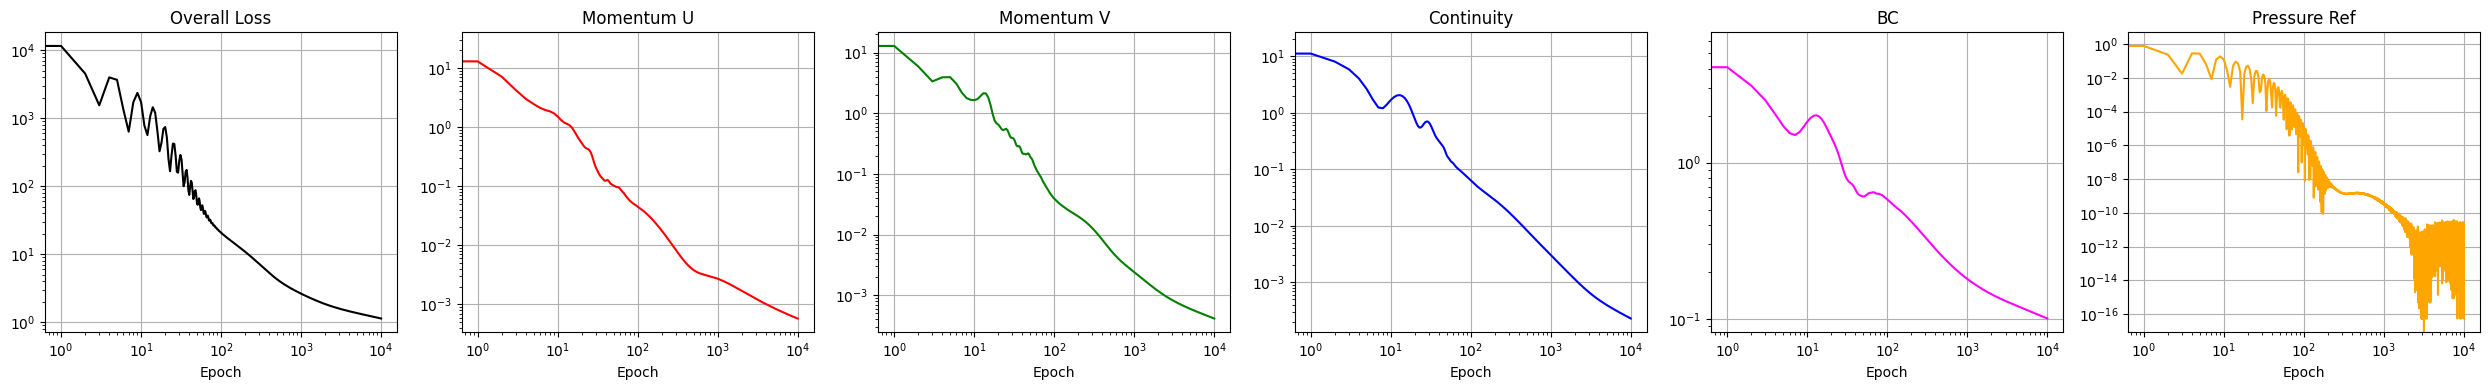

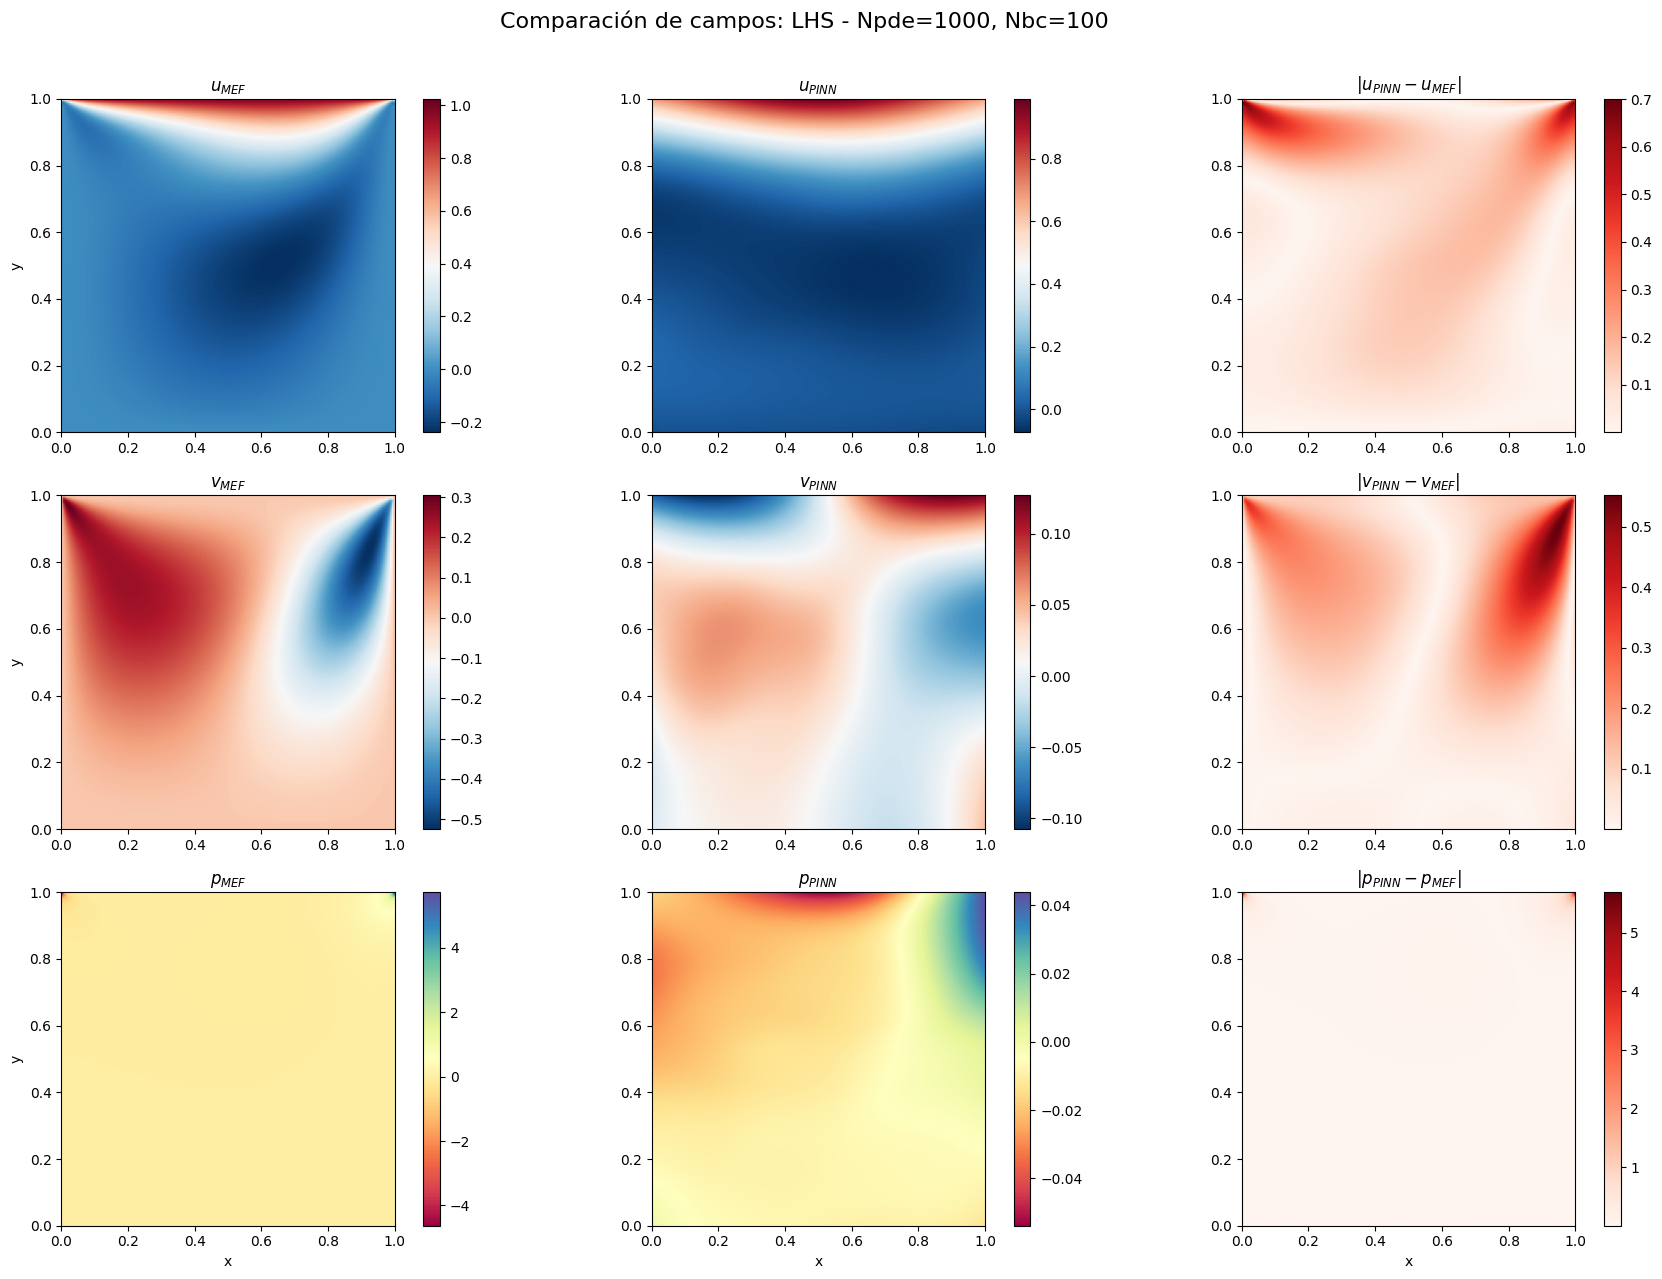


=== Entrenando modelo: lhs_Npde10000_Nbc1000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 6/10000 [00:00<03:09, 52.61it/s]

Epoch    0 | Total: 8.20e+03 | PDE: 4.89e+01 | BC: 5.57e+00 | P_ref: 3.26e-01 | p(0,0): 0.8900 | u_top: 0.822


Entrenando modelo PINN:   5%|▌         | 510/10000 [00:07<02:16, 69.27it/s]

Epoch  500 | Total: 4.30e+00 | PDE: 1.84e-02 | BC: 2.46e-01 | P_ref: 2.71e-09 | p(0,0): -0.0001 | u_top: 0.653


Entrenando modelo PINN:  10%|█         | 1007/10000 [00:14<02:20, 64.12it/s]

Epoch 1000 | Total: 2.67e+00 | PDE: 8.42e-03 | BC: 1.82e-01 | P_ref: 4.27e-10 | p(0,0): -0.0000 | u_top: 0.749


Entrenando modelo PINN:  15%|█▌        | 1513/10000 [00:22<01:58, 71.74it/s]

Epoch 1500 | Total: 2.12e+00 | PDE: 5.39e-03 | BC: 1.58e-01 | P_ref: 6.86e-11 | p(0,0): -0.0000 | u_top: 0.783


Entrenando modelo PINN:  20%|██        | 2010/10000 [00:29<01:54, 69.97it/s]

Epoch 2000 | Total: 1.85e+00 | PDE: 3.99e-03 | BC: 1.45e-01 | P_ref: 2.33e-12 | p(0,0): -0.0000 | u_top: 0.802


Entrenando modelo PINN:  25%|██▌       | 2510/10000 [00:36<01:49, 68.31it/s]

Epoch 2500 | Total: 1.69e+00 | PDE: 3.24e-03 | BC: 1.37e-01 | P_ref: 2.45e-14 | p(0,0): -0.0000 | u_top: 0.816


Entrenando modelo PINN:  30%|███       | 3015/10000 [00:43<01:39, 70.39it/s]

Epoch 3000 | Total: 1.58e+00 | PDE: 2.78e-03 | BC: 1.30e-01 | P_ref: 3.12e-13 | p(0,0): 0.0000 | u_top: 0.825


Entrenando modelo PINN:  35%|███▌      | 3509/10000 [00:50<01:31, 71.21it/s]

Epoch 3500 | Total: 1.50e+00 | PDE: 2.46e-03 | BC: 1.26e-01 | P_ref: 3.99e-12 | p(0,0): 0.0000 | u_top: 0.833


Entrenando modelo PINN:  40%|████      | 4015/10000 [00:57<01:22, 72.97it/s]

Epoch 4000 | Total: 1.44e+00 | PDE: 2.23e-03 | BC: 1.22e-01 | P_ref: 6.68e-12 | p(0,0): 0.0000 | u_top: 0.839


Entrenando modelo PINN:  45%|████▌     | 4514/10000 [01:04<01:17, 71.04it/s]

Epoch 4500 | Total: 1.39e+00 | PDE: 2.06e-03 | BC: 1.19e-01 | P_ref: 1.04e-11 | p(0,0): 0.0000 | u_top: 0.844


Entrenando modelo PINN:  50%|█████     | 5012/10000 [01:12<01:11, 69.31it/s]

Epoch 5000 | Total: 1.35e+00 | PDE: 1.92e-03 | BC: 1.16e-01 | P_ref: 5.16e-12 | p(0,0): 0.0000 | u_top: 0.849


Entrenando modelo PINN:  55%|█████▌    | 5511/10000 [01:19<01:03, 70.91it/s]

Epoch 5500 | Total: 1.31e+00 | PDE: 1.80e-03 | BC: 1.13e-01 | P_ref: 6.19e-12 | p(0,0): 0.0000 | u_top: 0.853


Entrenando modelo PINN:  60%|██████    | 6014/10000 [01:26<00:56, 70.42it/s]

Epoch 6000 | Total: 1.28e+00 | PDE: 1.71e-03 | BC: 1.11e-01 | P_ref: 6.49e-12 | p(0,0): 0.0000 | u_top: 0.856


Entrenando modelo PINN:  65%|██████▌   | 6511/10000 [01:33<00:52, 66.09it/s]

Epoch 6500 | Total: 1.25e+00 | PDE: 1.63e-03 | BC: 1.09e-01 | P_ref: 7.36e-12 | p(0,0): 0.0000 | u_top: 0.860


Entrenando modelo PINN:  70%|███████   | 7010/10000 [01:40<00:41, 72.28it/s]

Epoch 7000 | Total: 1.22e+00 | PDE: 1.56e-03 | BC: 1.07e-01 | P_ref: 3.44e-12 | p(0,0): 0.0000 | u_top: 0.862


Entrenando modelo PINN:  75%|███████▌  | 7514/10000 [01:47<00:34, 71.55it/s]

Epoch 7500 | Total: 1.20e+00 | PDE: 1.49e-03 | BC: 1.05e-01 | P_ref: 3.14e-12 | p(0,0): 0.0000 | u_top: 0.865


Entrenando modelo PINN:  80%|████████  | 8009/10000 [01:54<00:27, 72.06it/s]

Epoch 8000 | Total: 1.18e+00 | PDE: 1.44e-03 | BC: 1.04e-01 | P_ref: 1.93e-11 | p(0,0): 0.0000 | u_top: 0.868


Entrenando modelo PINN:  85%|████████▌ | 8513/10000 [02:01<00:20, 73.89it/s]

Epoch 8500 | Total: 1.16e+00 | PDE: 1.39e-03 | BC: 1.02e-01 | P_ref: 4.80e-12 | p(0,0): 0.0000 | u_top: 0.870


Entrenando modelo PINN:  90%|█████████ | 9014/10000 [02:08<00:13, 72.38it/s]

Epoch 9000 | Total: 1.14e+00 | PDE: 1.35e-03 | BC: 1.01e-01 | P_ref: 9.38e-13 | p(0,0): 0.0000 | u_top: 0.872


Entrenando modelo PINN:  95%|█████████▌| 9510/10000 [02:15<00:06, 72.49it/s]

Epoch 9500 | Total: 1.12e+00 | PDE: 1.31e-03 | BC: 9.93e-02 | P_ref: 1.14e-12 | p(0,0): 0.0000 | u_top: 0.874


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:22<00:00, 70.17it/s]


Epoch 9999 | Total: 1.11e+00 | PDE: 1.27e-03 | BC: 9.80e-02 | P_ref: 3.96e-12 | p(0,0): 0.0000 | u_top: 0.876

Tiempo total: 142.5 segundos
Modelo guardado como: models/pinn_lhs_Npde10000_Nbc1000_20250727_182347.pt
Plotting training losses for lhs_Npde10000_Nbc1000


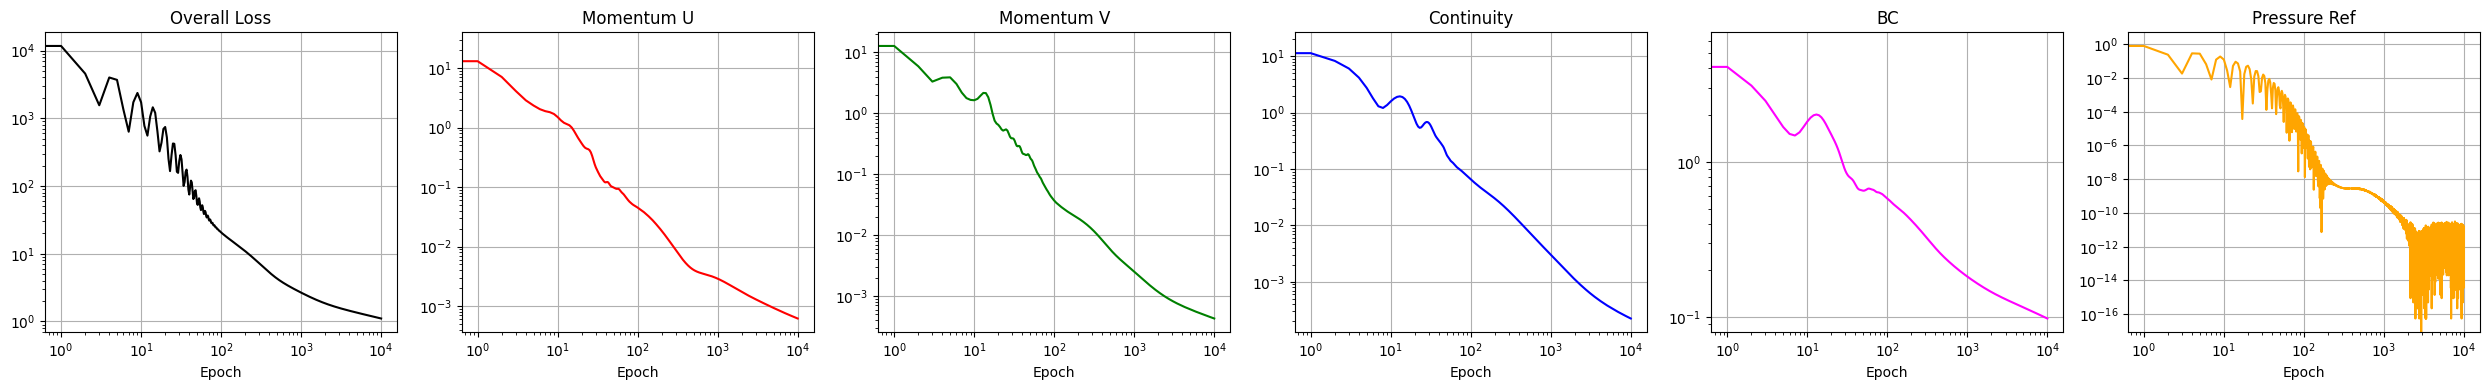

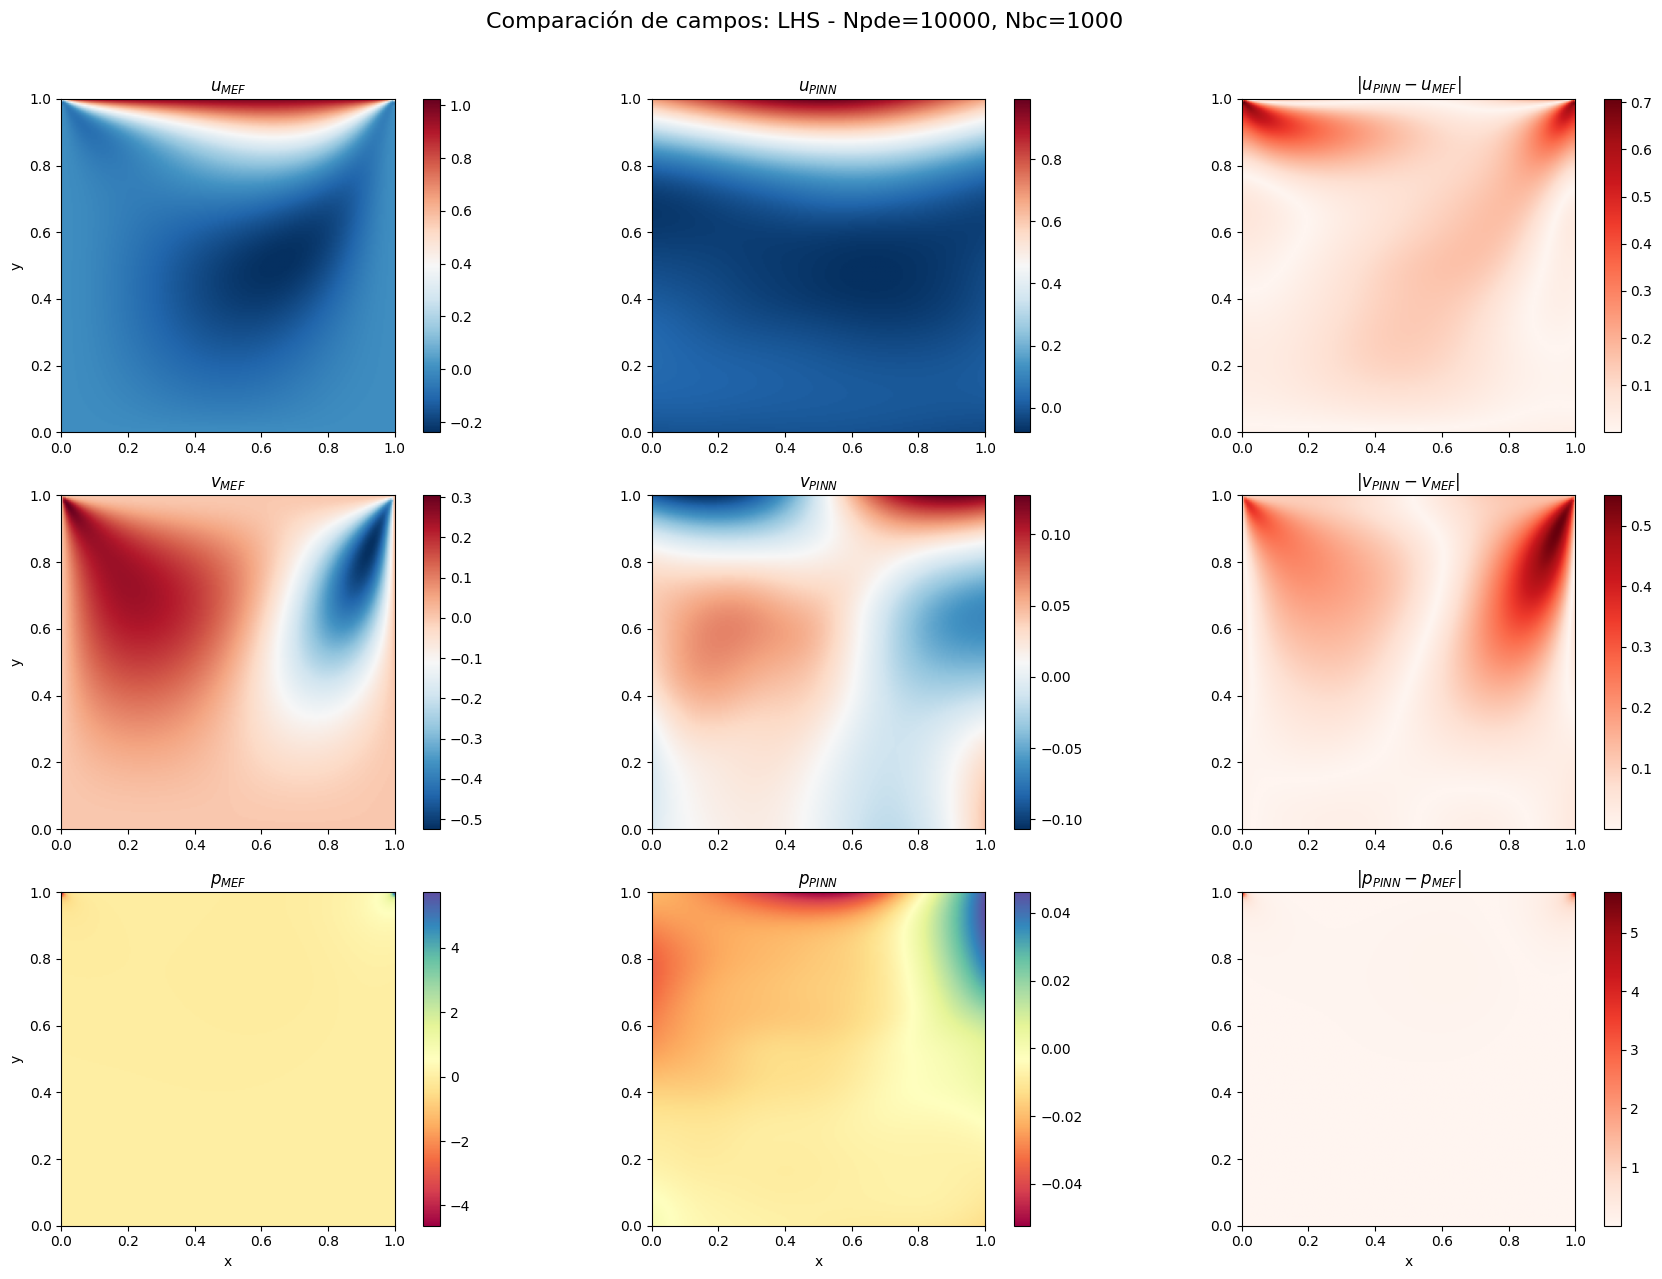


=== Entrenando modelo: lhs_Npde100000_Nbc10000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 2/10000 [00:00<13:45, 12.11it/s]

Epoch    0 | Total: 8.27e+03 | PDE: 4.96e+01 | BC: 5.57e+00 | P_ref: 3.26e-01 | p(0,0): 0.8877 | u_top: 0.820


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:40<12:29, 12.68it/s]

Epoch  500 | Total: 4.27e+00 | PDE: 1.83e-02 | BC: 2.44e-01 | P_ref: 3.11e-09 | p(0,0): -0.0001 | u_top: 0.656


Entrenando modelo PINN:  10%|█         | 1002/10000 [01:19<11:53, 12.60it/s]

Epoch 1000 | Total: 2.67e+00 | PDE: 8.40e-03 | BC: 1.83e-01 | P_ref: 5.05e-10 | p(0,0): -0.0000 | u_top: 0.749


Entrenando modelo PINN:  15%|█▌        | 1502/10000 [01:59<11:19, 12.51it/s]

Epoch 1500 | Total: 2.12e+00 | PDE: 5.38e-03 | BC: 1.59e-01 | P_ref: 9.63e-11 | p(0,0): -0.0000 | u_top: 0.782


Entrenando modelo PINN:  20%|██        | 2002/10000 [02:39<10:36, 12.56it/s]

Epoch 2000 | Total: 1.85e+00 | PDE: 3.98e-03 | BC: 1.45e-01 | P_ref: 1.62e-11 | p(0,0): -0.0000 | u_top: 0.802


Entrenando modelo PINN:  25%|██▌       | 2502/10000 [03:19<09:59, 12.50it/s]

Epoch 2500 | Total: 1.69e+00 | PDE: 3.23e-03 | BC: 1.37e-01 | P_ref: 4.77e-12 | p(0,0): -0.0000 | u_top: 0.815


Entrenando modelo PINN:  30%|███       | 3002/10000 [03:58<09:17, 12.55it/s]

Epoch 3000 | Total: 1.58e+00 | PDE: 2.77e-03 | BC: 1.31e-01 | P_ref: 5.00e-16 | p(0,0): 0.0000 | u_top: 0.825


Entrenando modelo PINN:  35%|███▌      | 3502/10000 [04:38<08:39, 12.52it/s]

Epoch 3500 | Total: 1.51e+00 | PDE: 2.46e-03 | BC: 1.26e-01 | P_ref: 1.10e-11 | p(0,0): 0.0000 | u_top: 0.833


Entrenando modelo PINN:  40%|████      | 4002/10000 [05:17<07:54, 12.64it/s]

Epoch 4000 | Total: 1.44e+00 | PDE: 2.23e-03 | BC: 1.22e-01 | P_ref: 1.52e-11 | p(0,0): -0.0000 | u_top: 0.839


Entrenando modelo PINN:  45%|████▌     | 4502/10000 [05:57<07:17, 12.57it/s]

Epoch 4500 | Total: 1.39e+00 | PDE: 2.05e-03 | BC: 1.19e-01 | P_ref: 4.67e-12 | p(0,0): 0.0000 | u_top: 0.844


Entrenando modelo PINN:  50%|█████     | 5002/10000 [06:37<06:35, 12.63it/s]

Epoch 5000 | Total: 1.35e+00 | PDE: 1.92e-03 | BC: 1.16e-01 | P_ref: 9.75e-12 | p(0,0): 0.0000 | u_top: 0.849


Entrenando modelo PINN:  55%|█████▌    | 5502/10000 [07:16<05:57, 12.58it/s]

Epoch 5500 | Total: 1.31e+00 | PDE: 1.80e-03 | BC: 1.13e-01 | P_ref: 3.36e-12 | p(0,0): 0.0000 | u_top: 0.853


Entrenando modelo PINN:  60%|██████    | 6002/10000 [07:56<05:16, 12.63it/s]

Epoch 6000 | Total: 1.28e+00 | PDE: 1.71e-03 | BC: 1.11e-01 | P_ref: 9.93e-12 | p(0,0): 0.0000 | u_top: 0.856


Entrenando modelo PINN:  65%|██████▌   | 6502/10000 [08:36<04:37, 12.59it/s]

Epoch 6500 | Total: 1.25e+00 | PDE: 1.63e-03 | BC: 1.09e-01 | P_ref: 2.89e-12 | p(0,0): 0.0000 | u_top: 0.859


Entrenando modelo PINN:  70%|███████   | 7002/10000 [09:16<03:59, 12.51it/s]

Epoch 7000 | Total: 1.23e+00 | PDE: 1.56e-03 | BC: 1.07e-01 | P_ref: 6.27e-12 | p(0,0): 0.0000 | u_top: 0.862


Entrenando modelo PINN:  75%|███████▌  | 7502/10000 [09:56<03:18, 12.58it/s]

Epoch 7500 | Total: 1.20e+00 | PDE: 1.50e-03 | BC: 1.05e-01 | P_ref: 5.68e-14 | p(0,0): 0.0000 | u_top: 0.865


Entrenando modelo PINN:  80%|████████  | 8002/10000 [10:35<02:40, 12.44it/s]

Epoch 8000 | Total: 1.18e+00 | PDE: 1.44e-03 | BC: 1.04e-01 | P_ref: 5.97e-12 | p(0,0): 0.0000 | u_top: 0.867


Entrenando modelo PINN:  85%|████████▌ | 8502/10000 [11:16<02:04, 12.04it/s]

Epoch 8500 | Total: 1.16e+00 | PDE: 1.39e-03 | BC: 1.02e-01 | P_ref: 5.30e-12 | p(0,0): 0.0000 | u_top: 0.869


Entrenando modelo PINN:  90%|█████████ | 9002/10000 [11:56<01:19, 12.52it/s]

Epoch 9000 | Total: 1.14e+00 | PDE: 1.35e-03 | BC: 1.01e-01 | P_ref: 1.64e-12 | p(0,0): 0.0000 | u_top: 0.872


Entrenando modelo PINN:  95%|█████████▌| 9502/10000 [12:36<00:39, 12.50it/s]

Epoch 9500 | Total: 1.13e+00 | PDE: 1.31e-03 | BC: 9.95e-02 | P_ref: 7.97e-12 | p(0,0): 0.0000 | u_top: 0.874


Entrenando modelo PINN: 100%|██████████| 10000/10000 [13:16<00:00, 12.56it/s]


Epoch 9999 | Total: 1.11e+00 | PDE: 1.27e-03 | BC: 9.83e-02 | P_ref: 9.09e-13 | p(0,0): 0.0000 | u_top: 0.875

Tiempo total: 796.3 segundos
Modelo guardado como: models/pinn_lhs_Npde100000_Nbc10000_20250727_183706.pt
Plotting training losses for lhs_Npde100000_Nbc10000


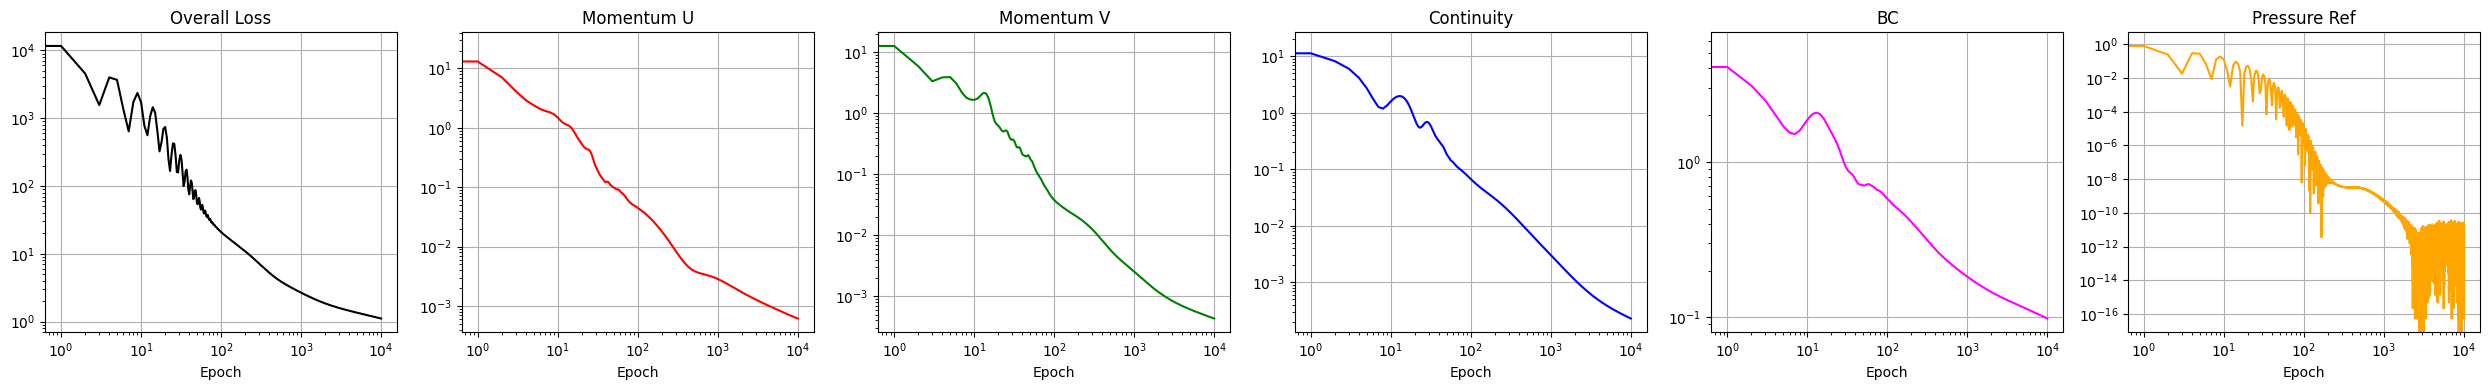

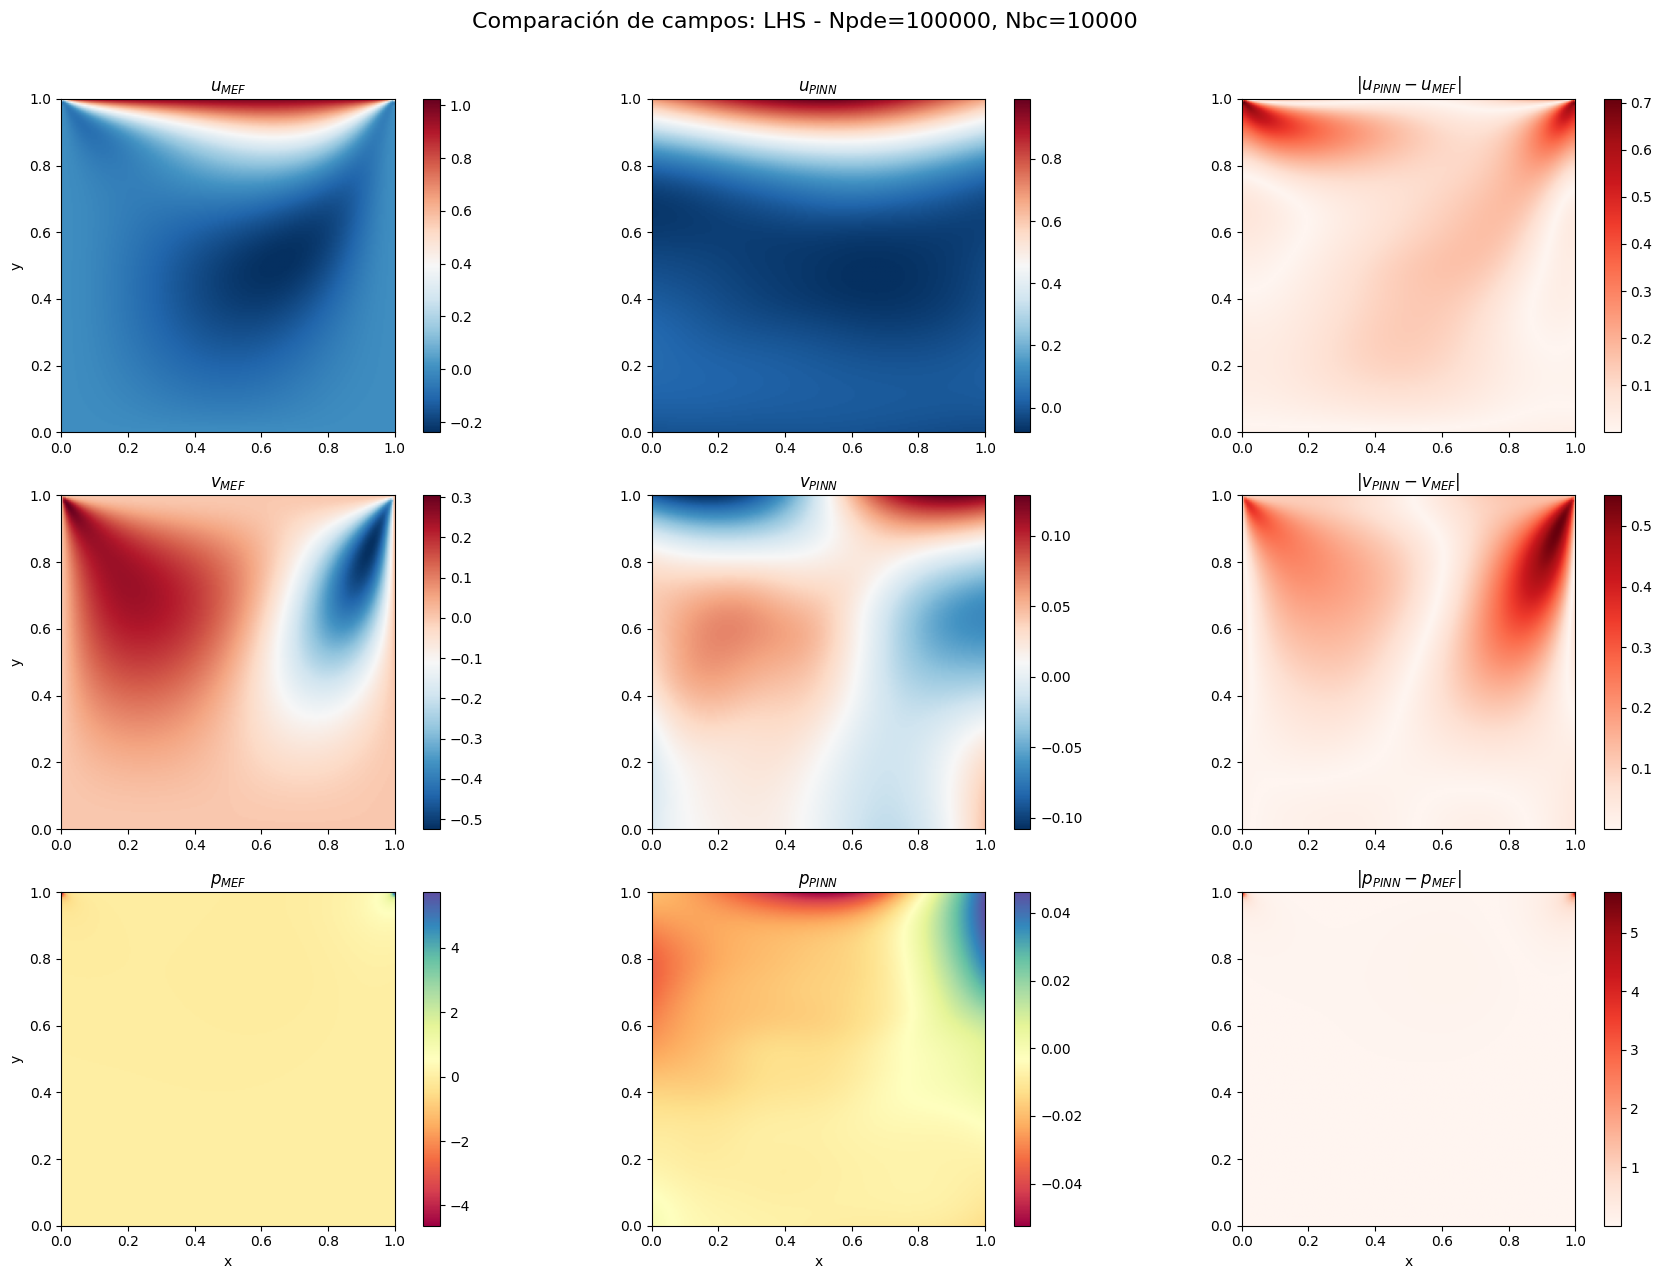


=== Entrenando modelo: rad_Npde1000_Nbc100 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 7/10000 [00:00<02:30, 66.61it/s]

Epoch    0 | Total: 6.86e+03 | PDE: 3.55e+01 | BC: 5.02e+00 | P_ref: 3.26e-01 | p(0,0): 0.9271 | u_top: 0.773


Entrenando modelo PINN:   5%|▌         | 512/10000 [00:07<02:18, 68.31it/s]

Epoch  500 | Total: 3.48e+00 | PDE: 5.68e-03 | BC: 2.91e-01 | P_ref: 4.95e-10 | p(0,0): -0.0000 | u_top: 0.633


Entrenando modelo PINN:  10%|█         | 1014/10000 [00:13<01:56, 77.03it/s]

Epoch 1000 | Total: 2.45e+00 | PDE: 3.12e-03 | BC: 2.14e-01 | P_ref: 5.13e-11 | p(0,0): -0.0000 | u_top: 0.737


Entrenando modelo PINN:  15%|█▌        | 1510/10000 [00:20<01:56, 73.18it/s]

Epoch 1500 | Total: 2.16e+00 | PDE: 2.26e-03 | BC: 1.94e-01 | P_ref: 3.33e-12 | p(0,0): -0.0000 | u_top: 0.766


Entrenando modelo PINN:  20%|██        | 2014/10000 [00:27<01:48, 73.63it/s]

Epoch 2000 | Total: 2.01e+00 | PDE: 1.81e-03 | BC: 1.82e-01 | P_ref: 8.40e-13 | p(0,0): -0.0000 | u_top: 0.781


Entrenando modelo PINN:  25%|██▌       | 2510/10000 [00:34<01:41, 74.08it/s]

Epoch 2500 | Total: 1.90e+00 | PDE: 1.54e-03 | BC: 1.75e-01 | P_ref: 8.67e-13 | p(0,0): 0.0000 | u_top: 0.792


Entrenando modelo PINN:  30%|███       | 3014/10000 [00:40<01:33, 74.46it/s]

Epoch 3000 | Total: 1.83e+00 | PDE: 1.36e-03 | BC: 1.69e-01 | P_ref: 8.88e-14 | p(0,0): -0.0000 | u_top: 0.800


Entrenando modelo PINN:  35%|███▌      | 3511/10000 [00:47<01:27, 73.85it/s]

Epoch 3500 | Total: 1.78e+00 | PDE: 1.23e-03 | BC: 1.65e-01 | P_ref: 4.51e-12 | p(0,0): -0.0000 | u_top: 0.806


Entrenando modelo PINN:  40%|████      | 4015/10000 [00:54<01:18, 76.48it/s]

Epoch 4000 | Total: 1.74e+00 | PDE: 1.13e-03 | BC: 1.63e-01 | P_ref: 3.92e-13 | p(0,0): -0.0000 | u_top: 0.810


Entrenando modelo PINN:  45%|████▌     | 4511/10000 [01:01<01:16, 71.36it/s]

Epoch 4500 | Total: 1.71e+00 | PDE: 1.05e-03 | BC: 1.60e-01 | P_ref: 2.88e-13 | p(0,0): 0.0000 | u_top: 0.814


Entrenando modelo PINN:  50%|█████     | 5008/10000 [01:08<01:14, 67.25it/s]

Epoch 5000 | Total: 1.68e+00 | PDE: 9.84e-04 | BC: 1.58e-01 | P_ref: 6.12e-13 | p(0,0): 0.0000 | u_top: 0.818


Entrenando modelo PINN:  55%|█████▌    | 5508/10000 [01:15<01:02, 71.69it/s]

Epoch 5500 | Total: 1.66e+00 | PDE: 9.28e-04 | BC: 1.57e-01 | P_ref: 1.25e-12 | p(0,0): 0.0000 | u_top: 0.821


Entrenando modelo PINN:  60%|██████    | 6010/10000 [01:22<00:59, 66.56it/s]

Epoch 6000 | Total: 1.64e+00 | PDE: 8.80e-04 | BC: 1.56e-01 | P_ref: 6.72e-15 | p(0,0): -0.0000 | u_top: 0.823


Entrenando modelo PINN:  65%|██████▌   | 6511/10000 [01:29<00:52, 66.45it/s]

Epoch 6500 | Total: 1.63e+00 | PDE: 8.39e-04 | BC: 1.54e-01 | P_ref: 1.74e-13 | p(0,0): -0.0000 | u_top: 0.825


Entrenando modelo PINN:  70%|███████   | 7014/10000 [01:36<00:41, 71.53it/s]

Epoch 7000 | Total: 1.61e+00 | PDE: 8.03e-04 | BC: 1.53e-01 | P_ref: 3.55e-13 | p(0,0): -0.0000 | u_top: 0.827


Entrenando modelo PINN:  75%|███████▌  | 7511/10000 [01:43<00:36, 69.01it/s]

Epoch 7500 | Total: 1.60e+00 | PDE: 7.72e-04 | BC: 1.53e-01 | P_ref: 8.88e-14 | p(0,0): 0.0000 | u_top: 0.829


Entrenando modelo PINN:  80%|████████  | 8008/10000 [01:50<00:27, 72.88it/s]

Epoch 8000 | Total: 1.59e+00 | PDE: 7.45e-04 | BC: 1.52e-01 | P_ref: 7.19e-14 | p(0,0): 0.0000 | u_top: 0.830


Entrenando modelo PINN:  85%|████████▌ | 8512/10000 [01:57<00:20, 72.41it/s]

Epoch 8500 | Total: 1.58e+00 | PDE: 7.21e-04 | BC: 1.51e-01 | P_ref: 7.99e-15 | p(0,0): 0.0000 | u_top: 0.832


Entrenando modelo PINN:  90%|█████████ | 9010/10000 [02:04<00:14, 66.62it/s]

Epoch 9000 | Total: 1.57e+00 | PDE: 7.01e-04 | BC: 1.50e-01 | P_ref: 2.09e-12 | p(0,0): 0.0000 | u_top: 0.833


Entrenando modelo PINN:  95%|█████████▌| 9510/10000 [02:11<00:07, 69.42it/s]

Epoch 9500 | Total: 1.56e+00 | PDE: 6.83e-04 | BC: 1.50e-01 | P_ref: 5.44e-13 | p(0,0): 0.0000 | u_top: 0.834


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:19<00:00, 71.89it/s]


Epoch 9999 | Total: 1.56e+00 | PDE: 6.67e-04 | BC: 1.49e-01 | P_ref: 2.99e-12 | p(0,0): -0.0000 | u_top: 0.835

Tiempo total: 139.1 segundos
Modelo guardado como: models/pinn_rad_Npde1000_Nbc100_20250727_183928.pt
Plotting training losses for rad_Npde1000_Nbc100


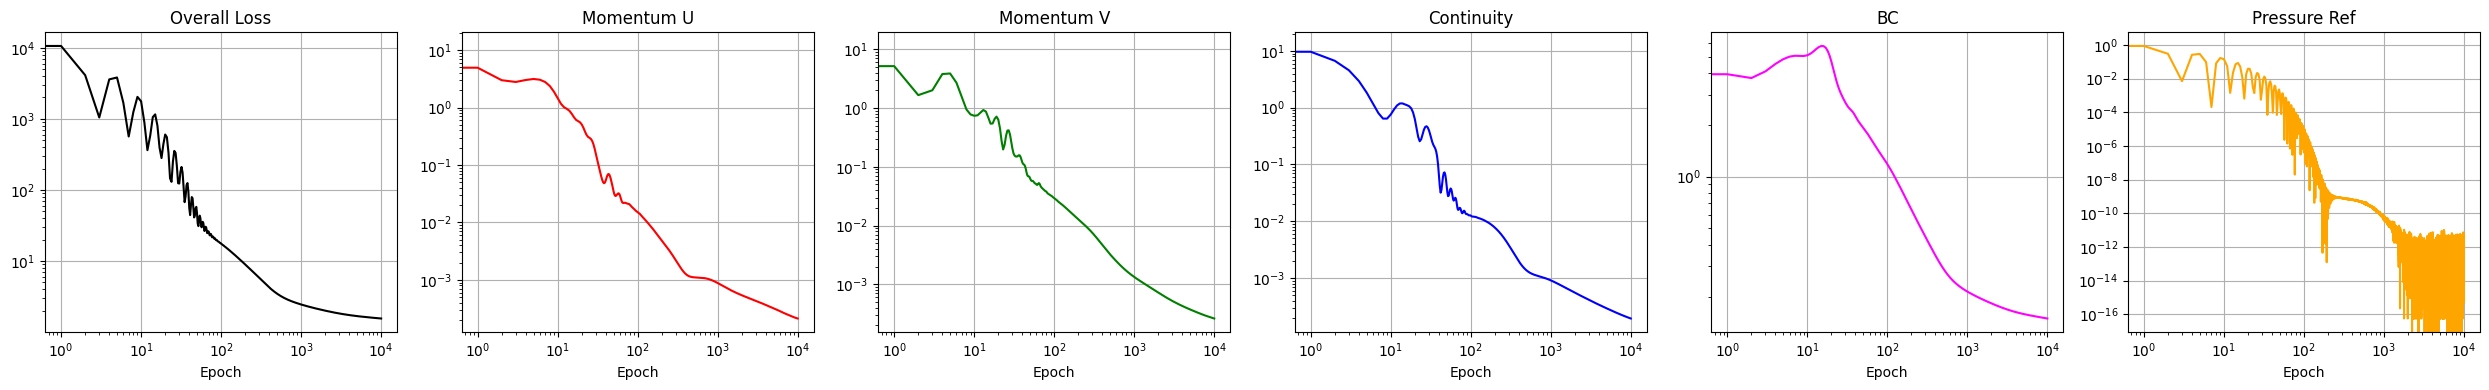

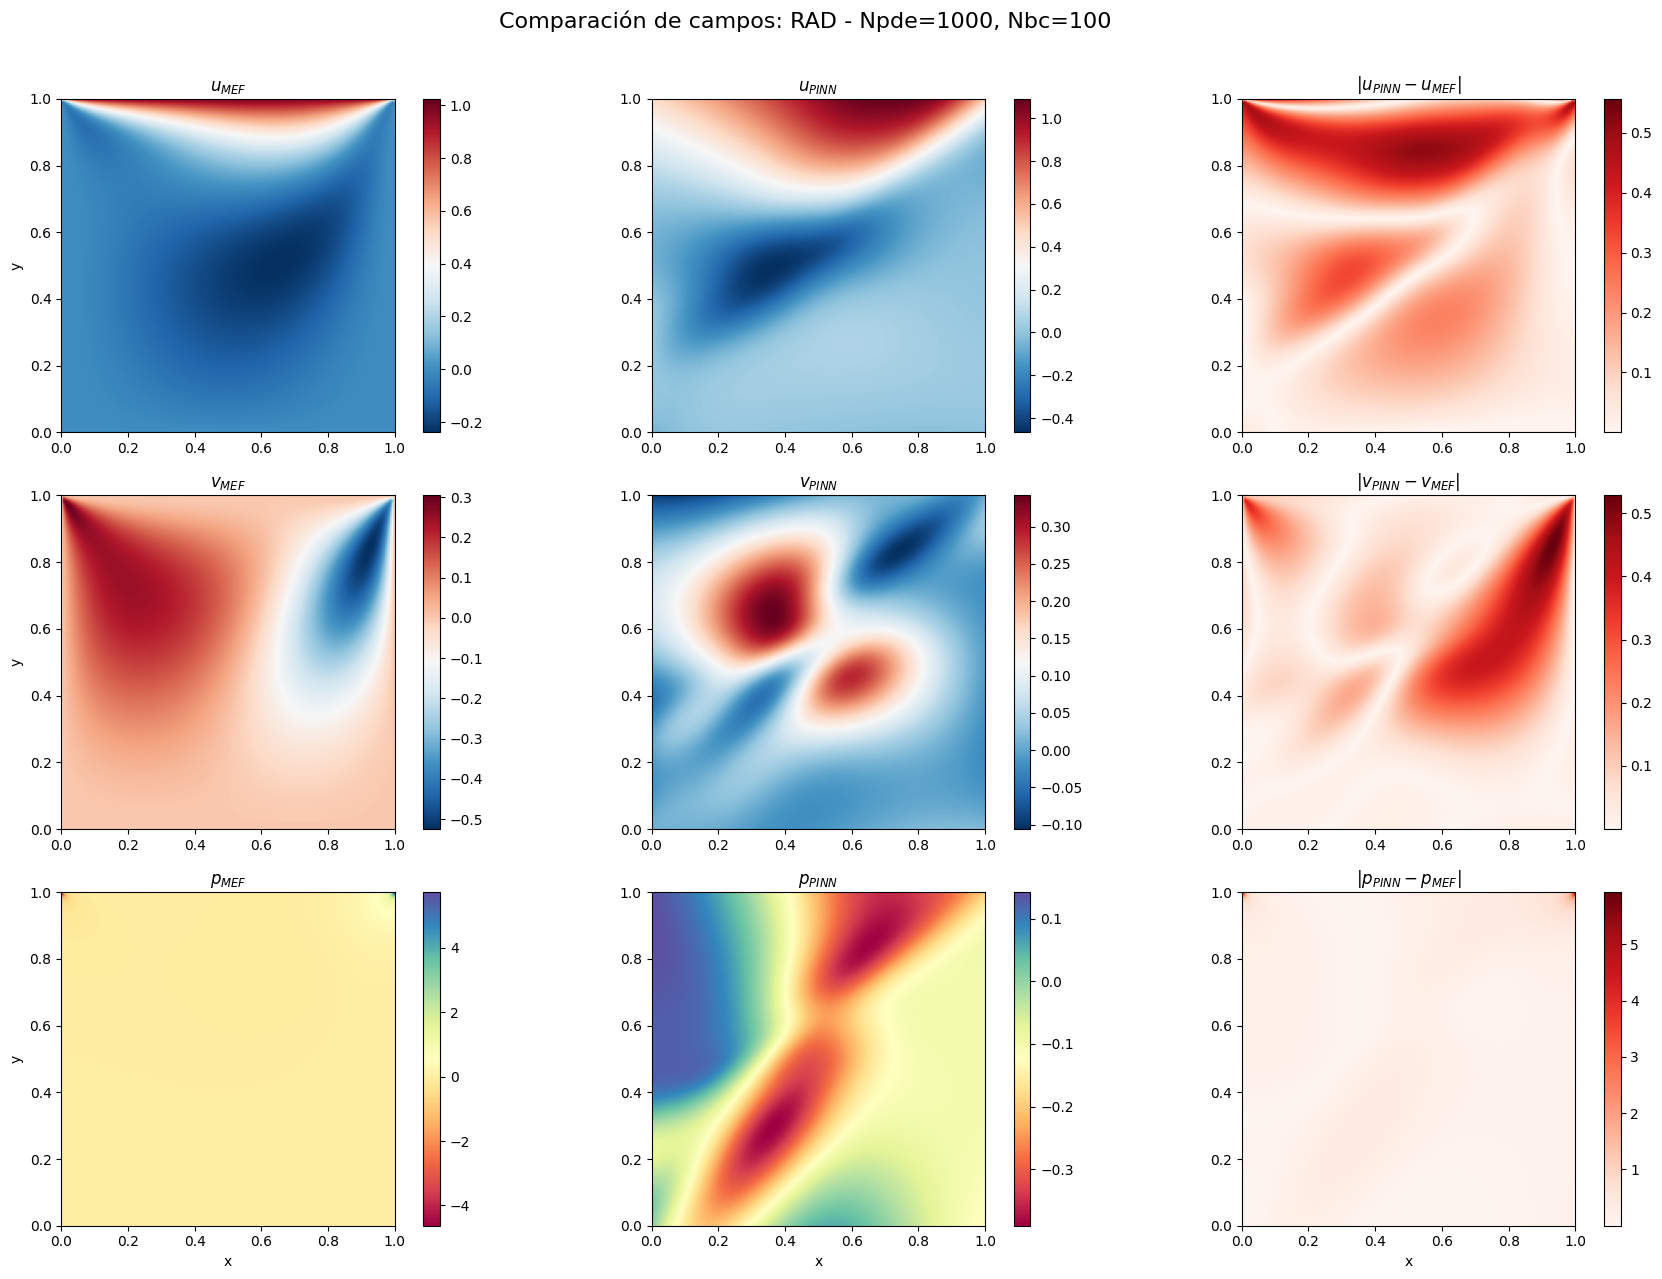


=== Entrenando modelo: rad_Npde10000_Nbc1000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 6/10000 [00:00<02:53, 57.58it/s]

Epoch    0 | Total: 7.35e+03 | PDE: 4.03e+01 | BC: 5.70e+00 | P_ref: 3.26e-01 | p(0,0): 0.9195 | u_top: 0.810


Entrenando modelo PINN:   5%|▌         | 509/10000 [00:07<02:11, 71.96it/s]

Epoch  500 | Total: 4.03e+00 | PDE: 1.72e-02 | BC: 2.31e-01 | P_ref: 5.99e-10 | p(0,0): -0.0000 | u_top: 0.647


Entrenando modelo PINN:  10%|█         | 1010/10000 [00:14<02:17, 65.31it/s]

Epoch 1000 | Total: 2.48e+00 | PDE: 8.21e-03 | BC: 1.66e-01 | P_ref: 7.05e-10 | p(0,0): -0.0000 | u_top: 0.765


Entrenando modelo PINN:  15%|█▌        | 1513/10000 [00:21<01:56, 72.94it/s]

Epoch 1500 | Total: 2.00e+00 | PDE: 5.41e-03 | BC: 1.46e-01 | P_ref: 2.40e-10 | p(0,0): -0.0000 | u_top: 0.800


Entrenando modelo PINN:  20%|██        | 2009/10000 [00:28<01:54, 70.03it/s]

Epoch 2000 | Total: 1.75e+00 | PDE: 4.04e-03 | BC: 1.35e-01 | P_ref: 1.31e-10 | p(0,0): -0.0000 | u_top: 0.818


Entrenando modelo PINN:  25%|██▌       | 2511/10000 [00:35<01:44, 71.42it/s]

Epoch 2500 | Total: 1.60e+00 | PDE: 3.27e-03 | BC: 1.28e-01 | P_ref: 2.15e-11 | p(0,0): -0.0000 | u_top: 0.830


Entrenando modelo PINN:  30%|███       | 3015/10000 [00:42<01:37, 71.35it/s]

Epoch 3000 | Total: 1.50e+00 | PDE: 2.77e-03 | BC: 1.22e-01 | P_ref: 9.38e-12 | p(0,0): -0.0000 | u_top: 0.838


Entrenando modelo PINN:  35%|███▌      | 3511/10000 [00:49<01:29, 72.46it/s]

Epoch 3500 | Total: 1.43e+00 | PDE: 2.43e-03 | BC: 1.19e-01 | P_ref: 1.04e-12 | p(0,0): -0.0000 | u_top: 0.845


Entrenando modelo PINN:  40%|████      | 4008/10000 [00:56<01:20, 74.34it/s]

Epoch 4000 | Total: 1.37e+00 | PDE: 2.19e-03 | BC: 1.15e-01 | P_ref: 2.64e-13 | p(0,0): -0.0000 | u_top: 0.850


Entrenando modelo PINN:  45%|████▌     | 4514/10000 [01:04<01:20, 68.07it/s]

Epoch 4500 | Total: 1.33e+00 | PDE: 2.01e-03 | BC: 1.13e-01 | P_ref: 1.18e-12 | p(0,0): 0.0000 | u_top: 0.855


Entrenando modelo PINN:  50%|█████     | 5013/10000 [01:11<01:08, 73.21it/s]

Epoch 5000 | Total: 1.29e+00 | PDE: 1.86e-03 | BC: 1.10e-01 | P_ref: 8.88e-16 | p(0,0): -0.0000 | u_top: 0.859


Entrenando modelo PINN:  55%|█████▌    | 5511/10000 [01:18<01:06, 67.90it/s]

Epoch 5500 | Total: 1.26e+00 | PDE: 1.74e-03 | BC: 1.08e-01 | P_ref: 2.20e-13 | p(0,0): 0.0000 | u_top: 0.862


Entrenando modelo PINN:  60%|██████    | 6016/10000 [01:25<00:53, 74.87it/s]

Epoch 6000 | Total: 1.23e+00 | PDE: 1.65e-03 | BC: 1.06e-01 | P_ref: 5.89e-13 | p(0,0): 0.0000 | u_top: 0.865


Entrenando modelo PINN:  65%|██████▌   | 6512/10000 [01:32<00:47, 72.69it/s]

Epoch 6500 | Total: 1.20e+00 | PDE: 1.57e-03 | BC: 1.05e-01 | P_ref: 2.22e-12 | p(0,0): 0.0000 | u_top: 0.868


Entrenando modelo PINN:  70%|███████   | 7015/10000 [01:39<00:41, 71.11it/s]

Epoch 7000 | Total: 1.18e+00 | PDE: 1.50e-03 | BC: 1.03e-01 | P_ref: 6.57e-12 | p(0,0): 0.0000 | u_top: 0.870


Entrenando modelo PINN:  75%|███████▌  | 7511/10000 [01:45<00:34, 71.65it/s]

Epoch 7500 | Total: 1.16e+00 | PDE: 1.44e-03 | BC: 1.02e-01 | P_ref: 1.44e-12 | p(0,0): 0.0000 | u_top: 0.872


Entrenando modelo PINN:  80%|████████  | 8015/10000 [01:52<00:27, 72.33it/s]

Epoch 8000 | Total: 1.14e+00 | PDE: 1.39e-03 | BC: 1.00e-01 | P_ref: 1.51e-12 | p(0,0): -0.0000 | u_top: 0.874


Entrenando modelo PINN:  85%|████████▌ | 8511/10000 [01:59<00:20, 71.14it/s]

Epoch 8500 | Total: 1.13e+00 | PDE: 1.34e-03 | BC: 9.92e-02 | P_ref: 6.80e-12 | p(0,0): 0.0000 | u_top: 0.876


Entrenando modelo PINN:  90%|█████████ | 9010/10000 [02:07<00:14, 66.24it/s]

Epoch 9000 | Total: 1.11e+00 | PDE: 1.30e-03 | BC: 9.81e-02 | P_ref: 3.28e-12 | p(0,0): 0.0000 | u_top: 0.878


Entrenando modelo PINN:  95%|█████████▌| 9509/10000 [02:14<00:06, 71.27it/s]

Epoch 9500 | Total: 1.10e+00 | PDE: 1.26e-03 | BC: 9.70e-02 | P_ref: 1.82e-12 | p(0,0): 0.0000 | u_top: 0.880


Entrenando modelo PINN: 100%|██████████| 10000/10000 [02:21<00:00, 70.90it/s]


Epoch 9999 | Total: 1.08e+00 | PDE: 1.23e-03 | BC: 9.60e-02 | P_ref: 9.38e-13 | p(0,0): 0.0000 | u_top: 0.881

Tiempo total: 141.0 segundos
Modelo guardado como: models/pinn_rad_Npde10000_Nbc1000_20250727_184152.pt
Plotting training losses for rad_Npde10000_Nbc1000


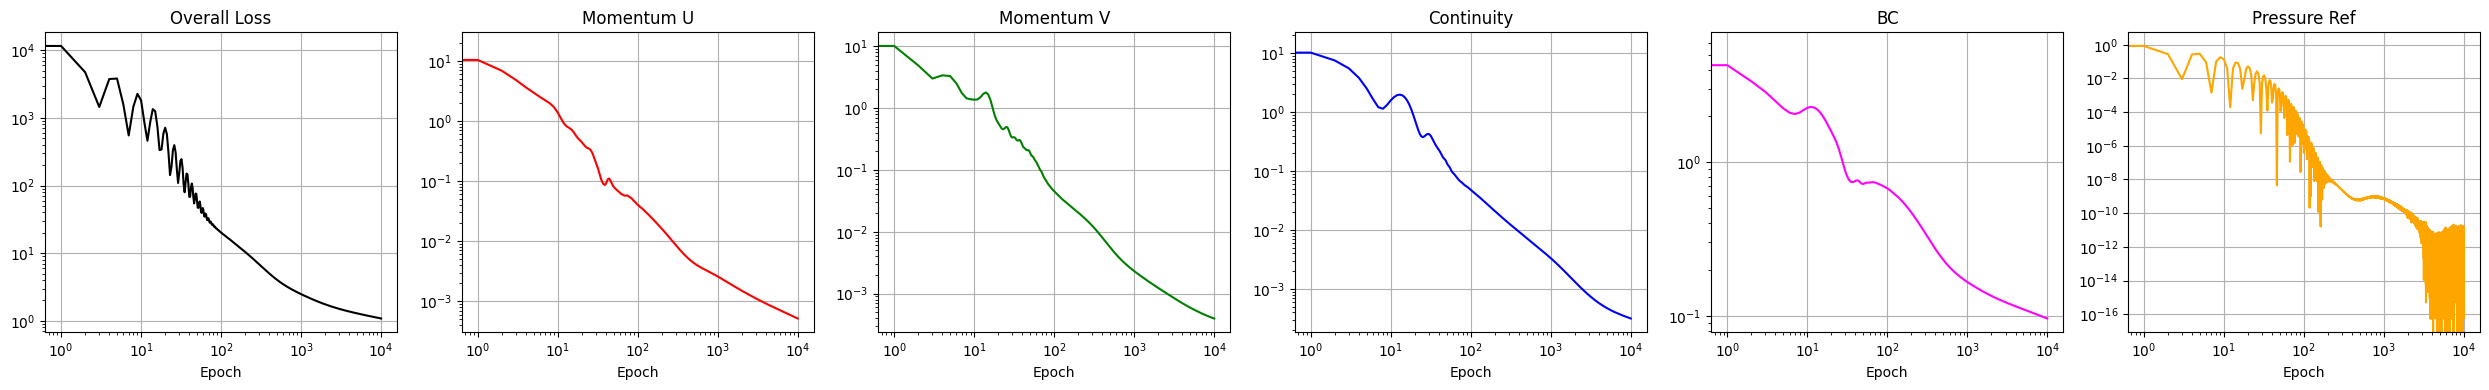

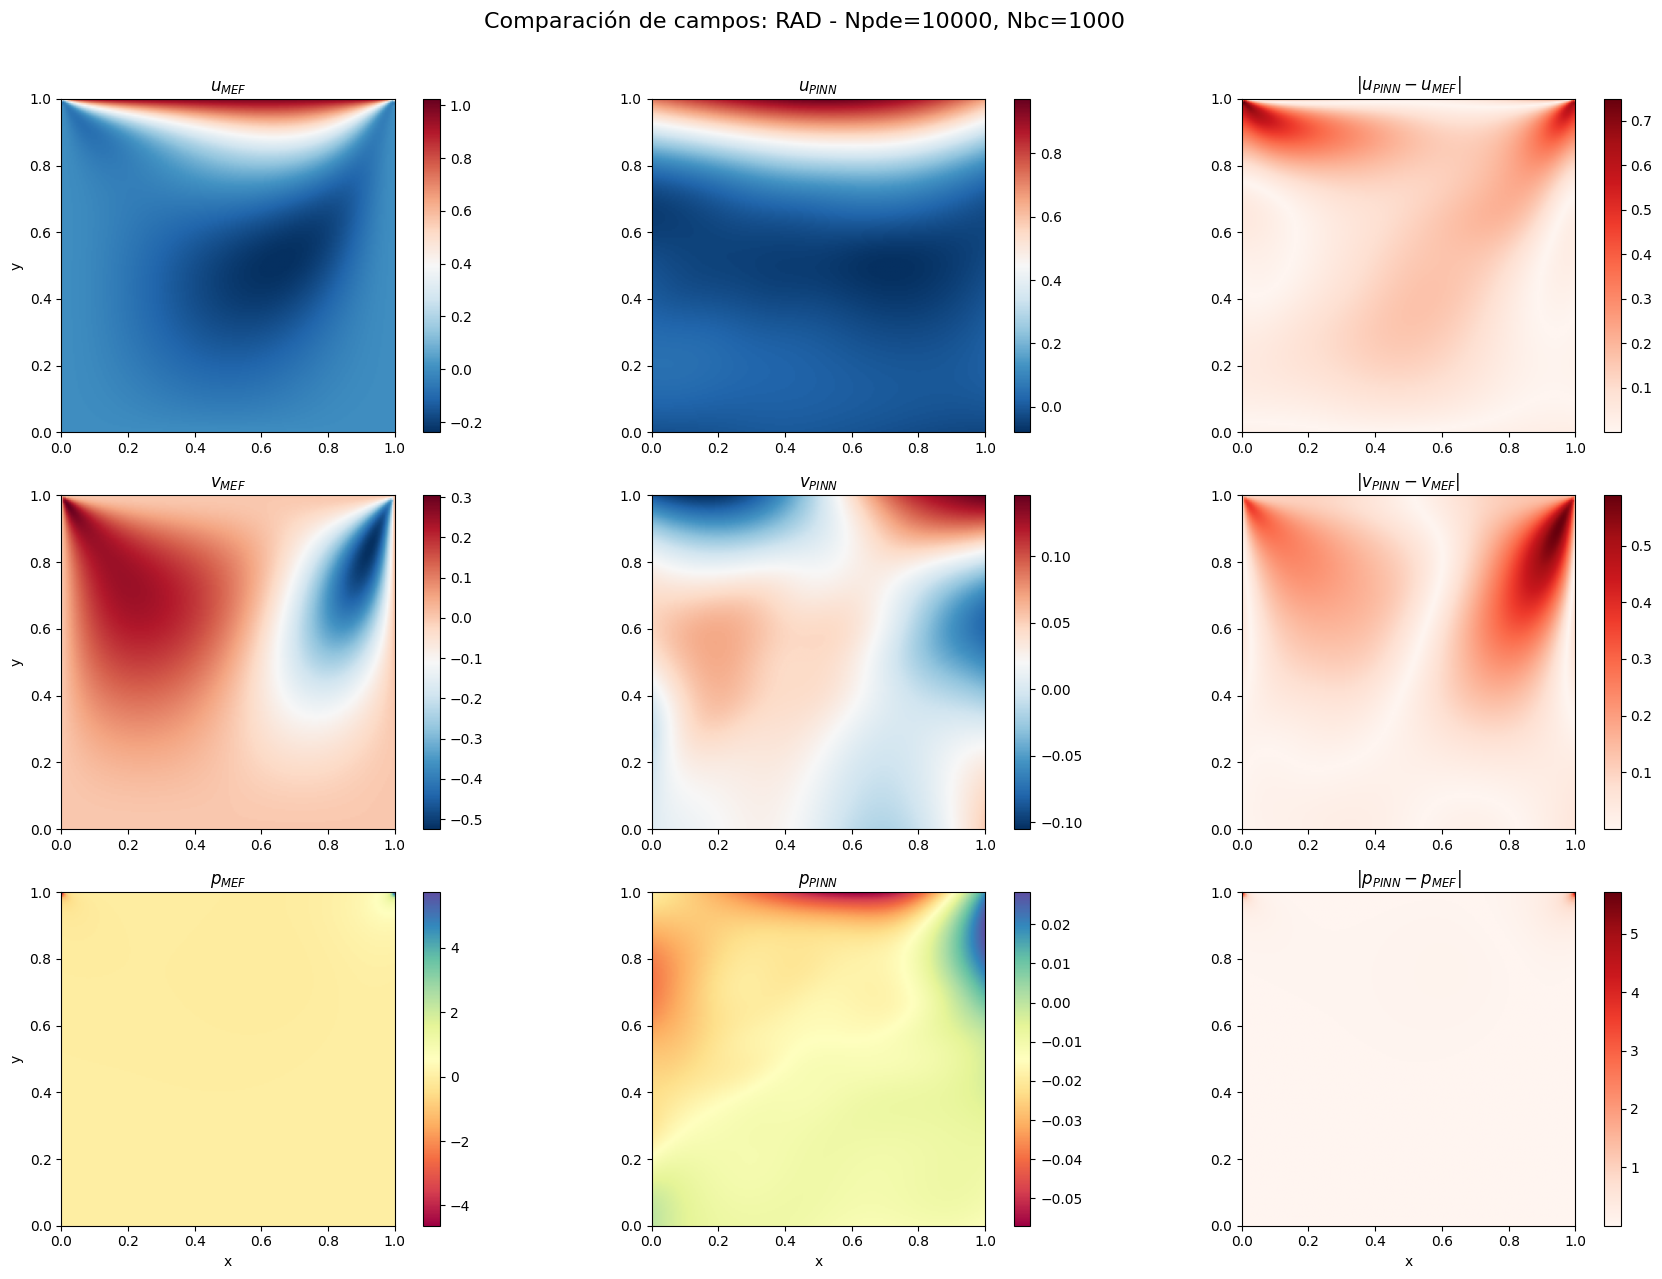


=== Entrenando modelo: rad_Npde100000_Nbc10000 ===
Iniciando entrenamiento ...


Entrenando modelo PINN:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch    0 | Total: 7.36e+03 | PDE: 4.04e+01 | BC: 5.67e+00 | P_ref: 3.26e-01 | p(0,0): 0.9195 | u_top: 0.799


Entrenando modelo PINN:   5%|▌         | 502/10000 [00:39<12:33, 12.60it/s]

Epoch  500 | Total: 4.24e+00 | PDE: 1.83e-02 | BC: 2.41e-01 | P_ref: 3.06e-10 | p(0,0): -0.0000 | u_top: 0.629


Entrenando modelo PINN:  10%|█         | 1002/10000 [01:19<11:54, 12.59it/s]

Epoch 1000 | Total: 2.57e+00 | PDE: 8.56e-03 | BC: 1.71e-01 | P_ref: 5.05e-10 | p(0,0): -0.0000 | u_top: 0.756


Entrenando modelo PINN:  15%|█▌        | 1502/10000 [01:58<11:17, 12.54it/s]

Epoch 1500 | Total: 2.07e+00 | PDE: 5.63e-03 | BC: 1.51e-01 | P_ref: 1.56e-10 | p(0,0): -0.0000 | u_top: 0.793


Entrenando modelo PINN:  20%|██        | 2002/10000 [02:38<10:37, 12.54it/s]

Epoch 2000 | Total: 1.81e+00 | PDE: 4.17e-03 | BC: 1.40e-01 | P_ref: 5.97e-11 | p(0,0): -0.0000 | u_top: 0.811


Entrenando modelo PINN:  25%|██▌       | 2502/10000 [03:18<09:58, 12.53it/s]

Epoch 2500 | Total: 1.66e+00 | PDE: 3.34e-03 | BC: 1.32e-01 | P_ref: 1.67e-11 | p(0,0): -0.0000 | u_top: 0.824


Entrenando modelo PINN:  30%|███       | 3002/10000 [03:58<09:34, 12.19it/s]

Epoch 3000 | Total: 1.55e+00 | PDE: 2.83e-03 | BC: 1.27e-01 | P_ref: 3.33e-12 | p(0,0): -0.0000 | u_top: 0.832


Entrenando modelo PINN:  35%|███▌      | 3502/10000 [04:38<08:40, 12.48it/s]

Epoch 3500 | Total: 1.47e+00 | PDE: 2.48e-03 | BC: 1.22e-01 | P_ref: 1.07e-12 | p(0,0): -0.0000 | u_top: 0.839


Entrenando modelo PINN:  40%|████      | 4002/10000 [05:19<08:18, 12.03it/s]

Epoch 4000 | Total: 1.41e+00 | PDE: 2.24e-03 | BC: 1.19e-01 | P_ref: 2.22e-12 | p(0,0): -0.0000 | u_top: 0.845


Entrenando modelo PINN:  45%|████▌     | 4502/10000 [05:59<07:16, 12.59it/s]

Epoch 4500 | Total: 1.36e+00 | PDE: 2.06e-03 | BC: 1.16e-01 | P_ref: 1.39e-13 | p(0,0): 0.0000 | u_top: 0.850


Entrenando modelo PINN:  50%|█████     | 5002/10000 [06:39<06:40, 12.49it/s]

Epoch 5000 | Total: 1.32e+00 | PDE: 1.92e-03 | BC: 1.13e-01 | P_ref: 1.23e-12 | p(0,0): 0.0000 | u_top: 0.854


Entrenando modelo PINN:  55%|█████▌    | 5502/10000 [07:19<06:10, 12.13it/s]

Epoch 5500 | Total: 1.29e+00 | PDE: 1.81e-03 | BC: 1.11e-01 | P_ref: 4.67e-14 | p(0,0): 0.0000 | u_top: 0.858


Entrenando modelo PINN:  60%|██████    | 6002/10000 [08:00<05:31, 12.04it/s]

Epoch 6000 | Total: 1.26e+00 | PDE: 1.71e-03 | BC: 1.09e-01 | P_ref: 1.15e-11 | p(0,0): 0.0000 | u_top: 0.861


Entrenando modelo PINN:  65%|██████▌   | 6502/10000 [08:42<04:38, 12.55it/s]

Epoch 6500 | Total: 1.23e+00 | PDE: 1.63e-03 | BC: 1.07e-01 | P_ref: 4.51e-12 | p(0,0): 0.0000 | u_top: 0.864


Entrenando modelo PINN:  70%|███████   | 7002/10000 [09:21<03:56, 12.68it/s]

Epoch 7000 | Total: 1.21e+00 | PDE: 1.56e-03 | BC: 1.05e-01 | P_ref: 3.53e-12 | p(0,0): 0.0000 | u_top: 0.867


Entrenando modelo PINN:  75%|███████▌  | 7502/10000 [10:01<03:21, 12.40it/s]

Epoch 7500 | Total: 1.18e+00 | PDE: 1.49e-03 | BC: 1.03e-01 | P_ref: 2.57e-12 | p(0,0): 0.0000 | u_top: 0.869


Entrenando modelo PINN:  80%|████████  | 8002/10000 [10:41<02:39, 12.50it/s]

Epoch 8000 | Total: 1.16e+00 | PDE: 1.44e-03 | BC: 1.02e-01 | P_ref: 3.58e-12 | p(0,0): 0.0000 | u_top: 0.871


Entrenando modelo PINN:  85%|████████▌ | 8502/10000 [11:20<01:59, 12.59it/s]

Epoch 8500 | Total: 1.14e+00 | PDE: 1.38e-03 | BC: 1.00e-01 | P_ref: 1.88e-12 | p(0,0): 0.0000 | u_top: 0.873


Entrenando modelo PINN:  90%|█████████ | 9002/10000 [12:01<01:19, 12.61it/s]

Epoch 9000 | Total: 1.13e+00 | PDE: 1.34e-03 | BC: 9.92e-02 | P_ref: 6.19e-12 | p(0,0): 0.0000 | u_top: 0.875


Entrenando modelo PINN:  95%|█████████▌| 9502/10000 [12:41<00:39, 12.51it/s]

Epoch 9500 | Total: 1.11e+00 | PDE: 1.29e-03 | BC: 9.80e-02 | P_ref: 4.80e-12 | p(0,0): 0.0000 | u_top: 0.877


Entrenando modelo PINN: 100%|██████████| 10000/10000 [13:21<00:00, 12.48it/s]


Epoch 9999 | Total: 1.09e+00 | PDE: 1.25e-03 | BC: 9.68e-02 | P_ref: 1.84e-12 | p(0,0): 0.0000 | u_top: 0.879

Tiempo total: 801.5 segundos
Modelo guardado como: models/pinn_rad_Npde100000_Nbc10000_20250727_185517.pt
Plotting training losses for rad_Npde100000_Nbc10000


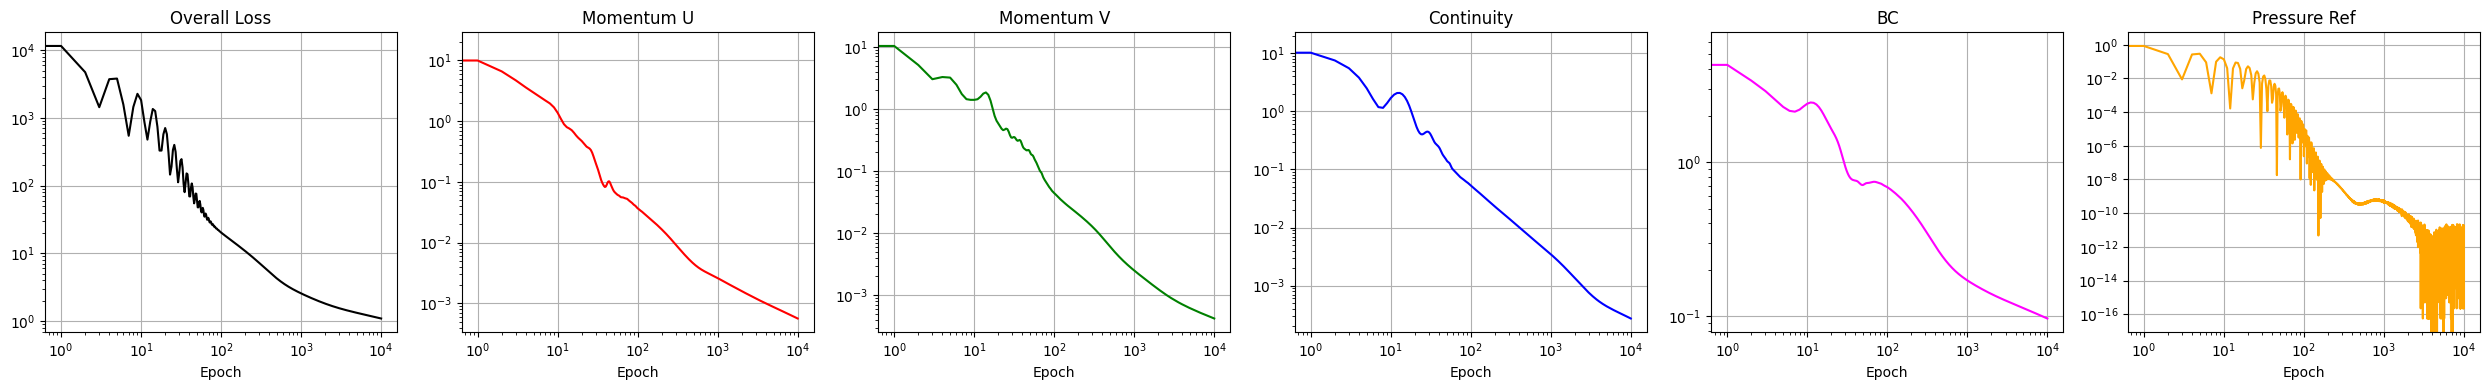

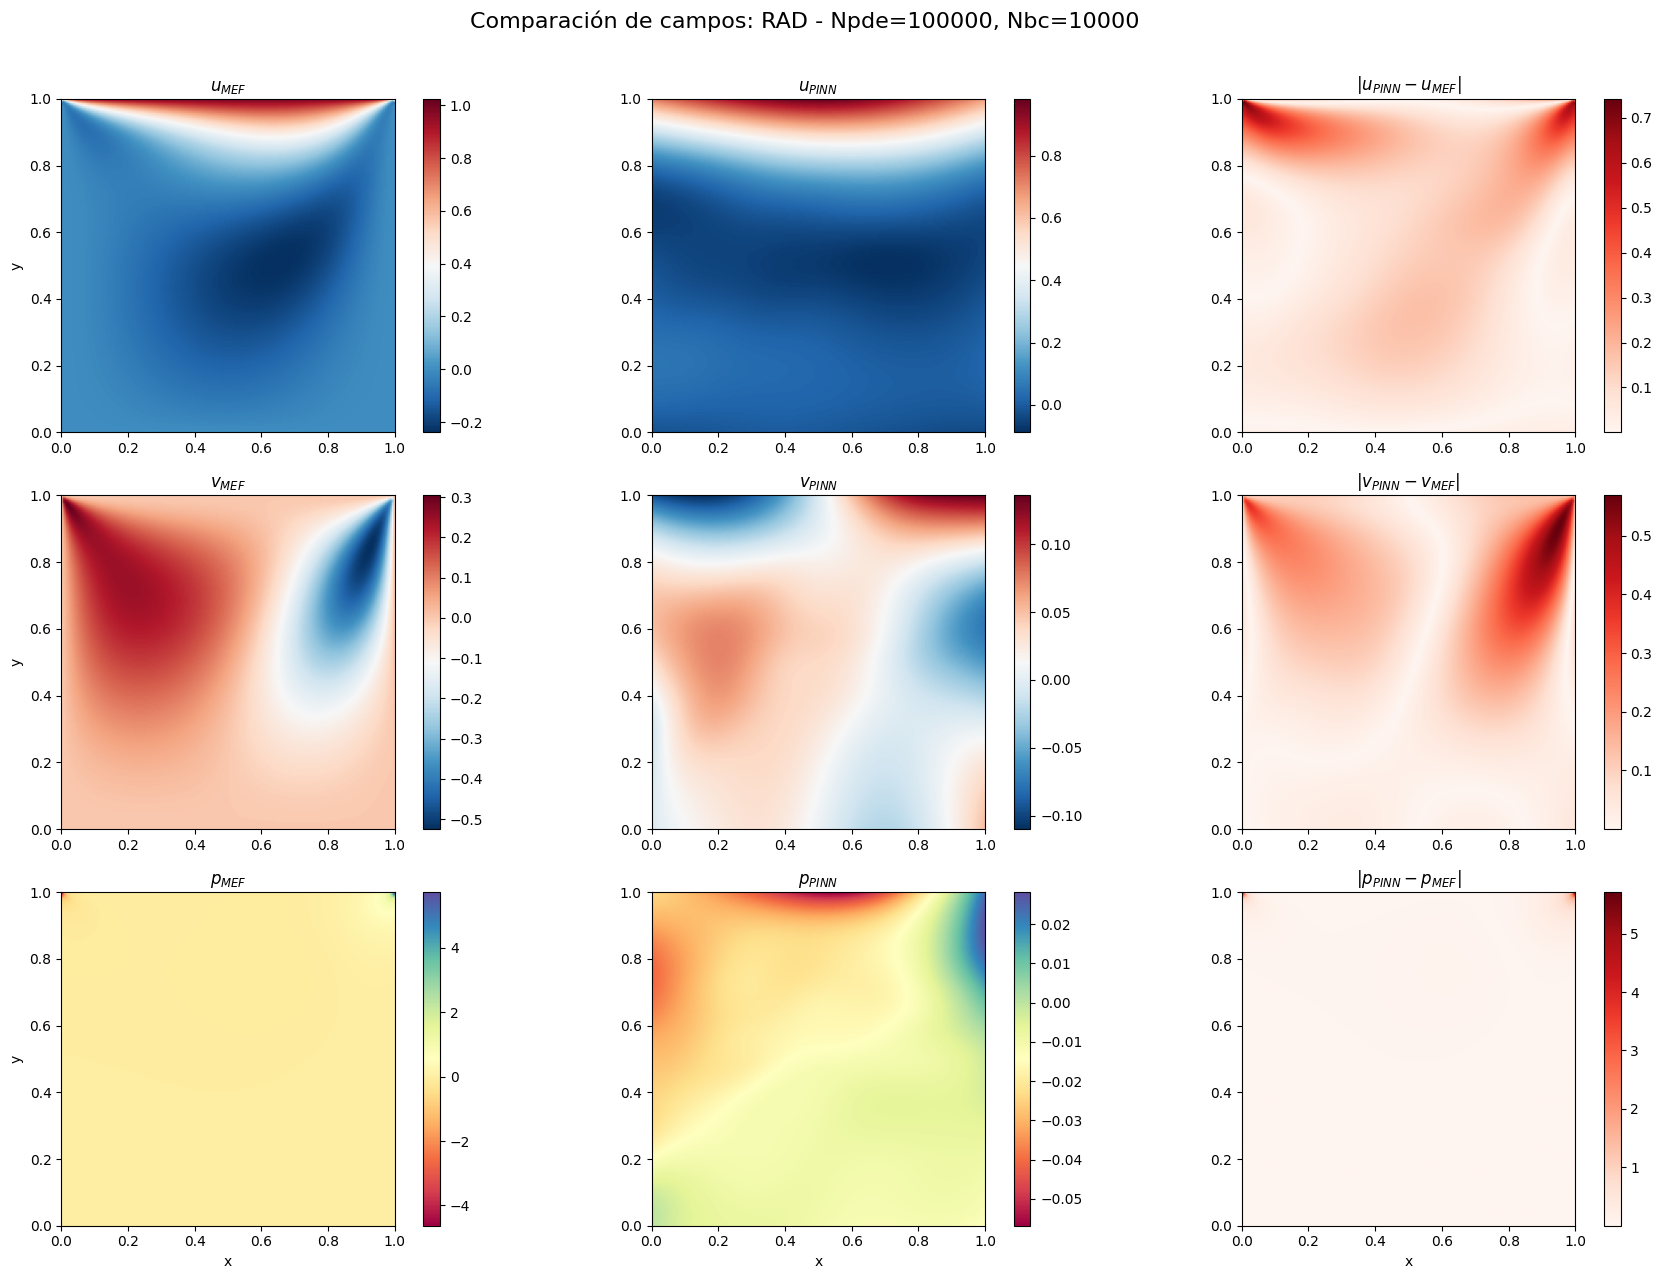

In [16]:
results = {}

error_metrics = {
    "strategy": [],
    "Npde": [],
    "Nbc": [],
    "error_u": [],
    "error_v": [],
    "error_p": [],
}

for strategy in strategies:
    for config in point_configs:
        Npde = config["Npde"]
        Nbc = config["Nbc"]
        key = f"{strategy}_Npde{Npde}_Nbc{Nbc}"

        print(f"\n=== Entrenando modelo: {key} ===")
        
        # Entrenar primero un modelo base para RAD
        if strategy == "rad" and f"uniform_Npde1000_Nbc100" not in results:
            print("Esperando modelo base uniform para usar en RAD...")
            continue  # saltar por ahora

        # Usar modelo base entrenado para RAD
        base_key = f"uniform_Npde{Npde}_Nbc{Nbc}"
        base_model = results.get(base_key, {}).get("model") if strategy == "rad" else None

        # Generar datos
        pde_points, bottom, top, left, right, bc_points = generate_collocation_points(
            strategy=strategy,
            N_pde=Npde,
            N_bc=Nbc,
            device=device,
            model=base_model
        )

        # Crear nuevo modelo
        torch.manual_seed(10)
        model = PINN_Module(model_parameters).to(device)

        # Optim y scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9995)

        # Entrenamiento
        losses = train_pinn(
            model, pde_points, top, bottom, left, right,
            epochs=10000, #TODO: change to 10k! just testing code functioning
            optimizer=optimizer,
            scheduler=scheduler,
            weight_pde=100.0,
            lambda_bc=10.0,                     # requerido por TP3
            weight_pressure_ref=10000.0,       # alto peso para condición de referencia
            strategy=strategy,
            Npde=Npde,
            Nbc=Nbc
        )

        # Guardar resultados
        results[key] = {
            "model": model,
            "losses": losses,
        }

        # Graficar pérdidas
        print(f"Plotting training losses for {key}")
        plot_losses(losses)

        # Evaluación de errores en malla de referencia 
        model.eval()
        with torch.no_grad():
            uvp_pred = model(X_eval)
            u_pred = uvp_pred[:, 0].cpu().numpy().reshape(201, 201)
            v_pred = uvp_pred[:, 1].cpu().numpy().reshape(201, 201)
            p_pred = uvp_pred[:, 2].cpu().numpy().reshape(201, 201)

        # Errores absolutos
        error_u = np.abs(u_pred - U_grid)
        error_v = np.abs(v_pred - V_grid)
        error_p = np.abs(p_pred - P_grid)

        # Normas-2 absolutas
        norm2_u = np.linalg.norm(error_u)
        norm2_v = np.linalg.norm(error_v)
        norm2_p = np.linalg.norm(error_p)

        plot_comparacion_uvp(
            u_pred, v_pred, p_pred,
            strategy, Npde, Nbc,
            U_grid, V_grid, P_grid,
            x, y
        )

        # Guardar en lista
        error_metrics["strategy"].append(strategy)
        error_metrics["Npde"].append(Npde)
        error_metrics["Nbc"].append(Nbc)
        error_metrics["error_u"].append(norm2_u)
        error_metrics["error_v"].append(norm2_v)
        error_metrics["error_p"].append(norm2_p)

### 4. Convergencia en cantidad de puntos de colocación. 

*Grafique los valores previamente calculados de la norma-2 del error en función del tamaño del dataset, en una gráfica doble logarítmica (loglog). ¿Observa un patrón de convergencia? ¿Es posible reportar una tasa de convergencia estable? ¿Cuál de todas las configuraciones alcanzó el mejor desempeño? ¿Es consistente esta conclusión con lo que usted esperaba? ¿Porqué si o porqué no?*

In [17]:
df_errors = pd.DataFrame(error_metrics)
df_errors.to_csv("error_metrics.csv", index=False)  # opcional
display(df_errors)

strategy    Npde    Nbc    error_u    error_v    error_p
0  uniform    1000    100  22.525907  26.915643  18.896814
1  uniform   10000   1000  28.030232  28.016068  19.280702
2  uniform  100000  10000  26.893002  27.648274  19.206866
3      lhs    1000    100  26.857446  27.875912  19.208881
4      lhs   10000   1000  26.117333  27.499245  19.155127
5      lhs  100000  10000  26.225824  27.594912  19.169930
6      rad    1000    100  40.325473  31.228020  40.545901
7      rad   10000   1000  29.612690  29.242241  19.542702
8      rad  100000  10000  28.822773  28.627247  19.414629

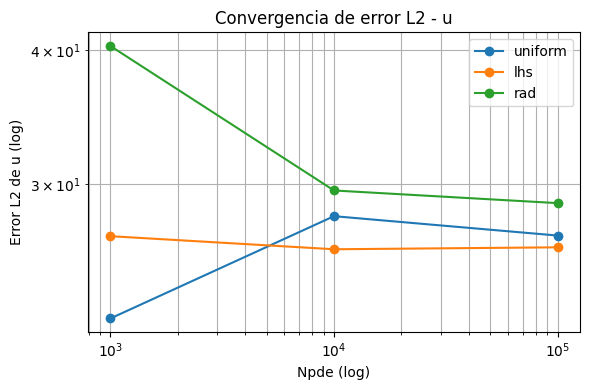

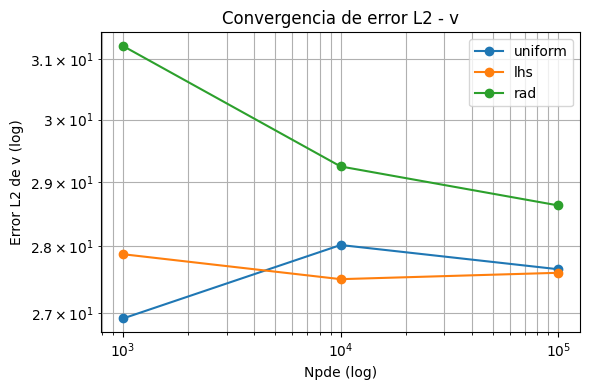

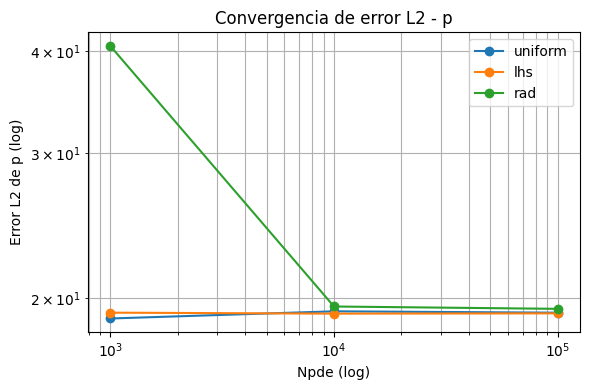

In [18]:
variables = ["error_u", "error_v", "error_p"]
labels = ["u", "v", "p"]

for var, label in zip(variables, labels):
    plt.figure(figsize=(6, 4))
    for strategy in df_errors["strategy"].unique():
        subset = df_errors[df_errors["strategy"] == strategy]
        subset = subset.sort_values("Npde")
        plt.loglog(subset["Npde"], subset[var], marker='o', label=strategy)

    plt.xlabel("Npde (log)")
    plt.ylabel(f"Error L2 de {label} (log)")
    plt.title(f"Convergencia de error L2 - {label}")
    plt.grid(True, which='both')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"./graficas/convergencia_loglog_{label}.png")
    plt.show()